In [110]:
!pip install ecg-plot
import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gender, age, labels, ecg_filenames = pc.import_key_data("/kaggle/input/")
ecg_filenames = np.asarray(ecg_filenames)

In [3]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [4]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


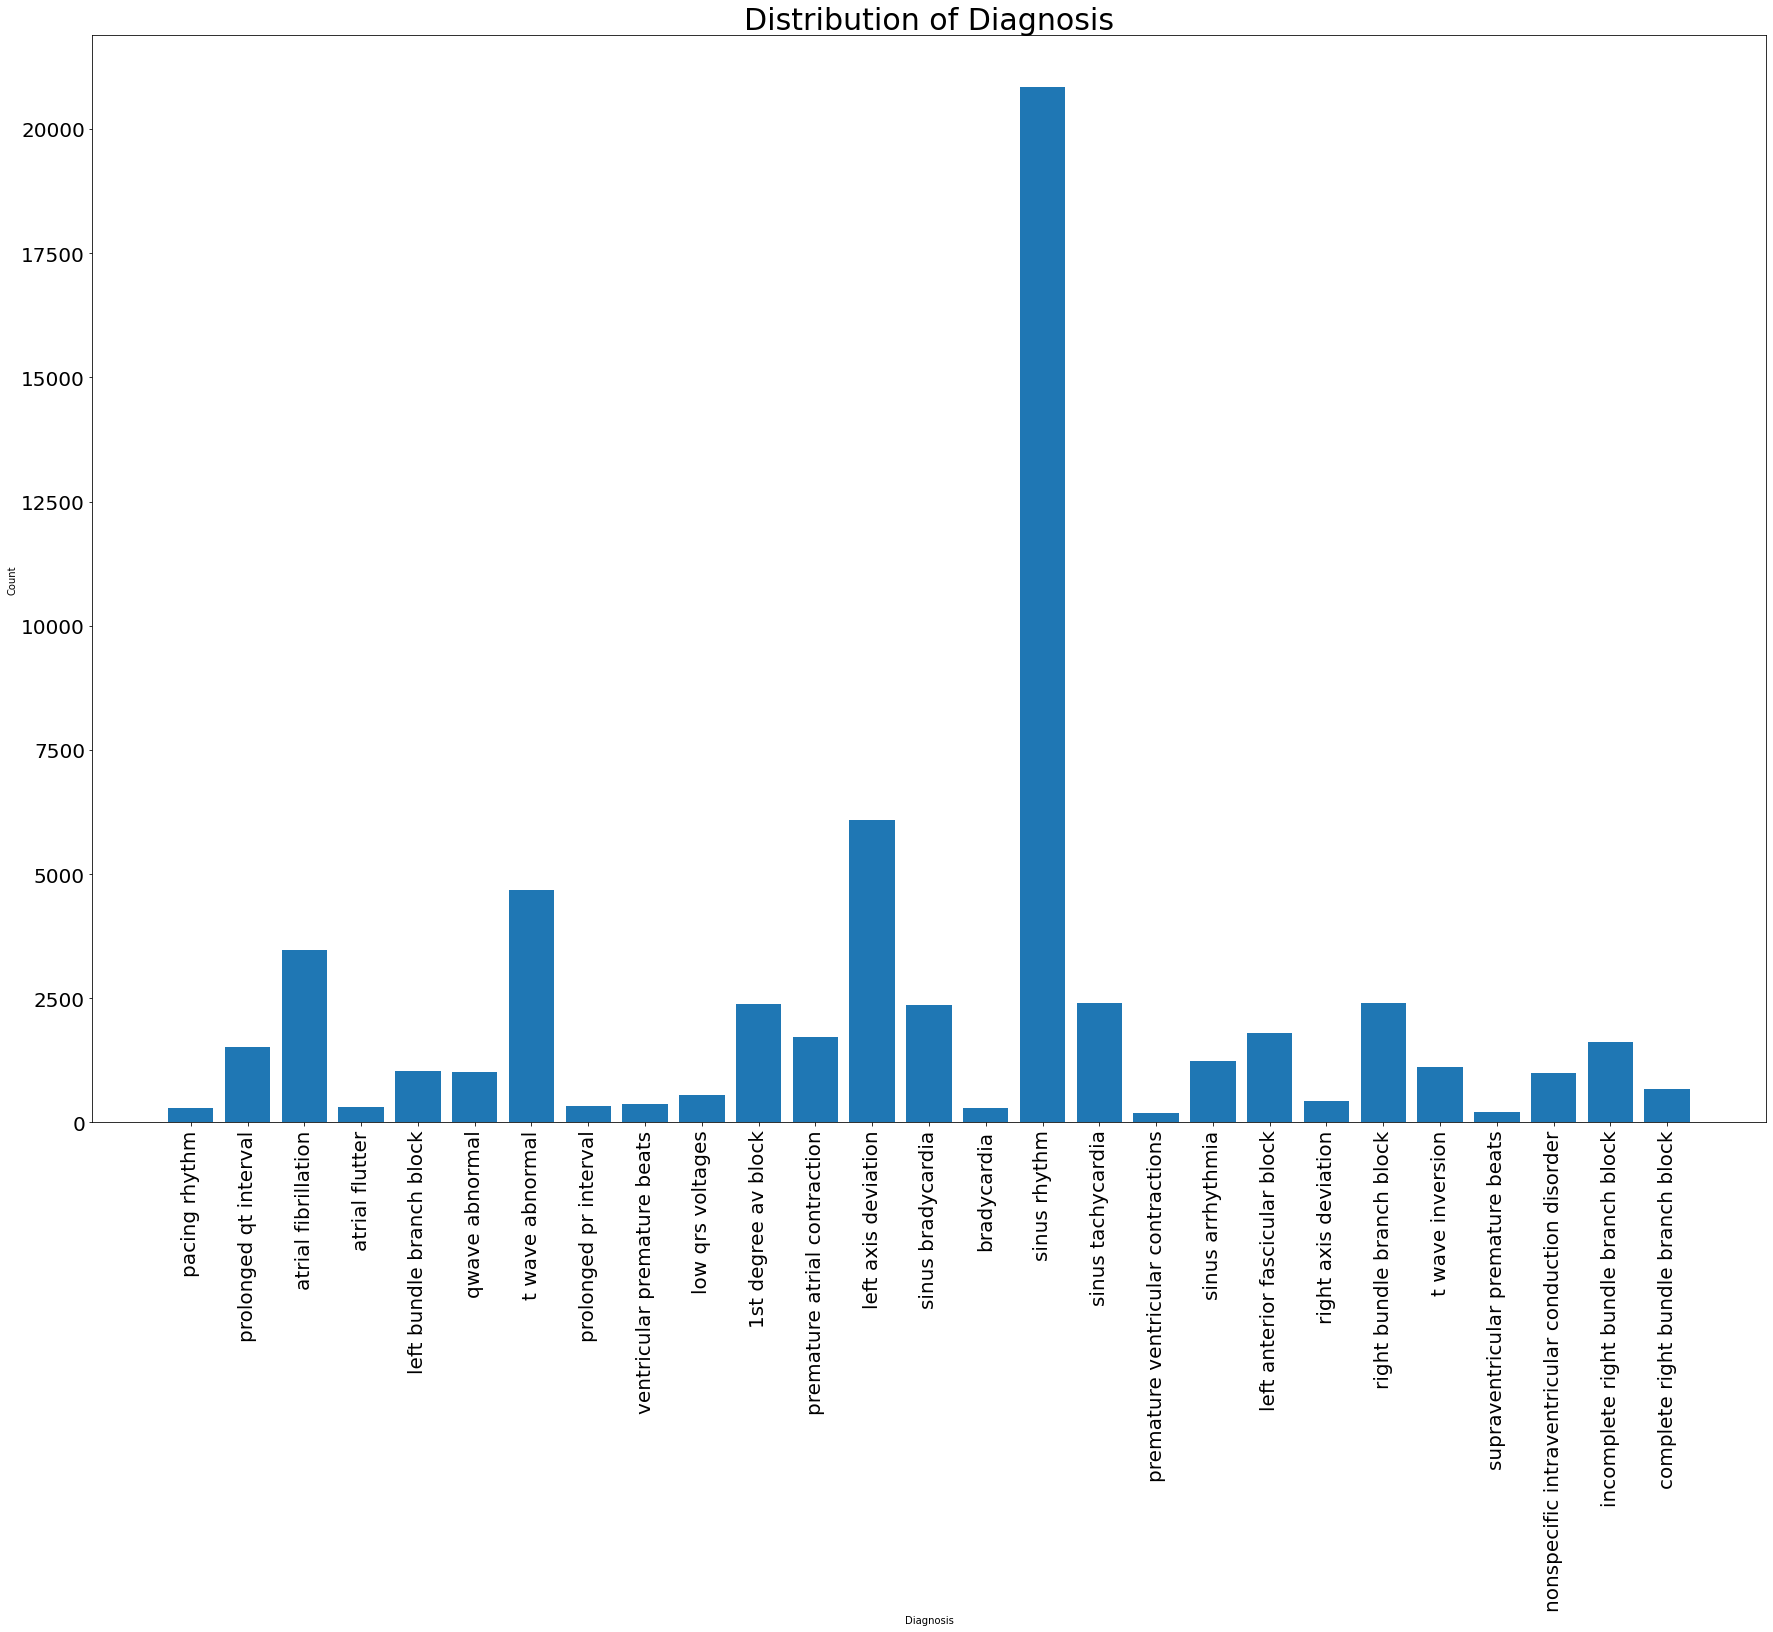

In [5]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [6]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [7]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


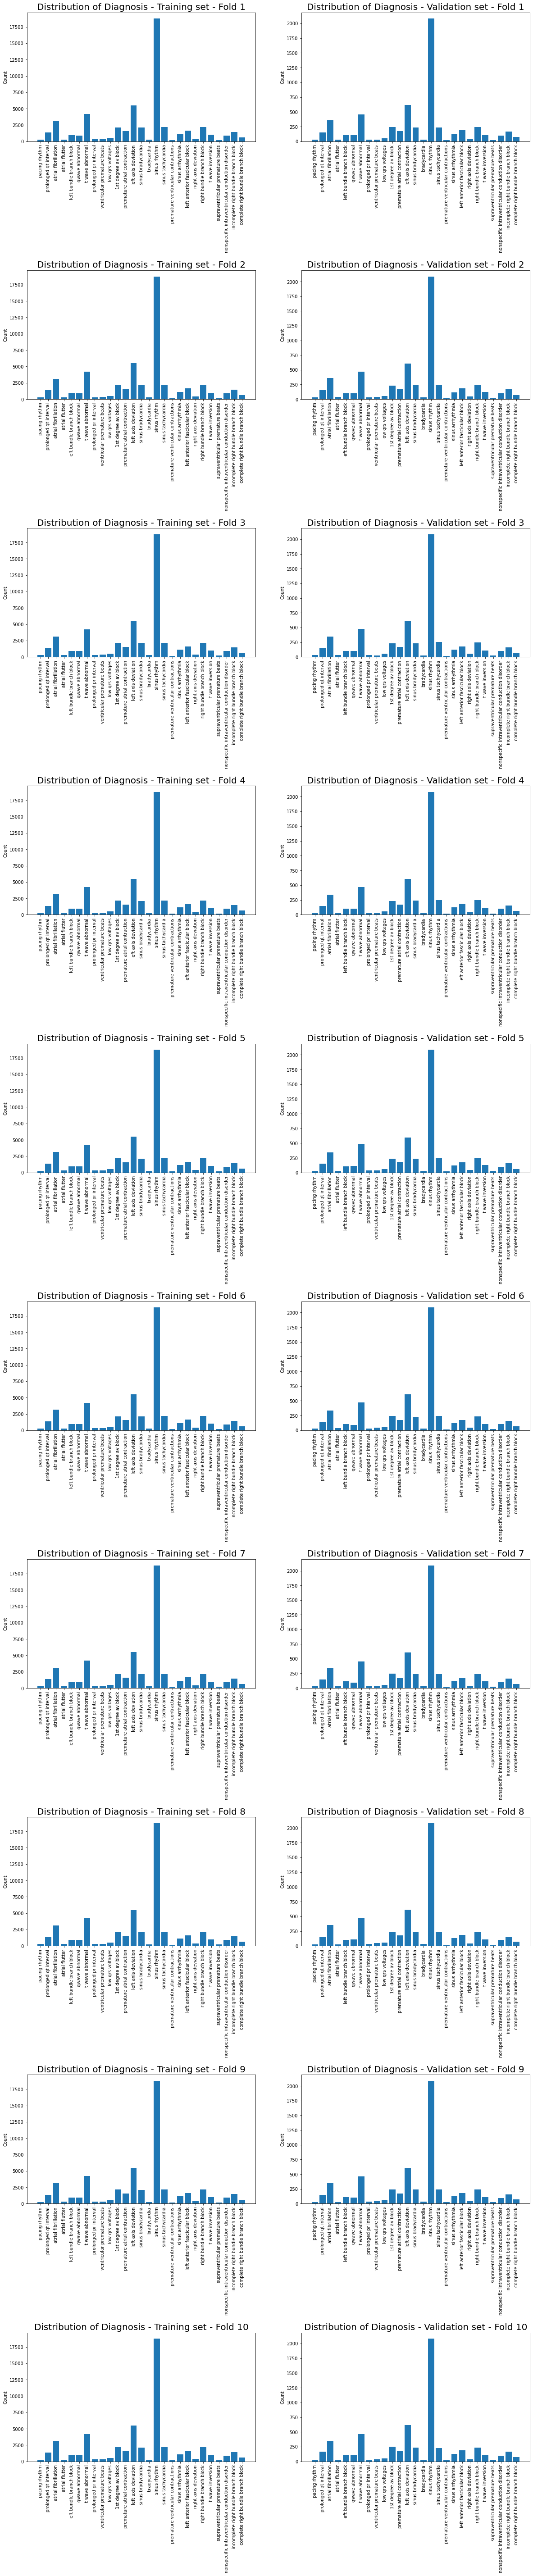

In [8]:
pc.plot_all_folds(folds,y,snomed_classes)

In [9]:
order_array = folds[0][0]

In [10]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [12]:
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [13]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [14]:
def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

In [15]:
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

In [16]:
def plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size

# Results

# Simple ANN

In [17]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(5000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(27, activation='sigmoid'))

In [18]:
 ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [19]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000, 50)          650       
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
dense_2 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
dense_3 (Dense)              (None, 5000, 50)          2550      
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1377      
Total params: 9,677
Trainable params: 9,677
Non-trainable params: 0
______________________________________________________

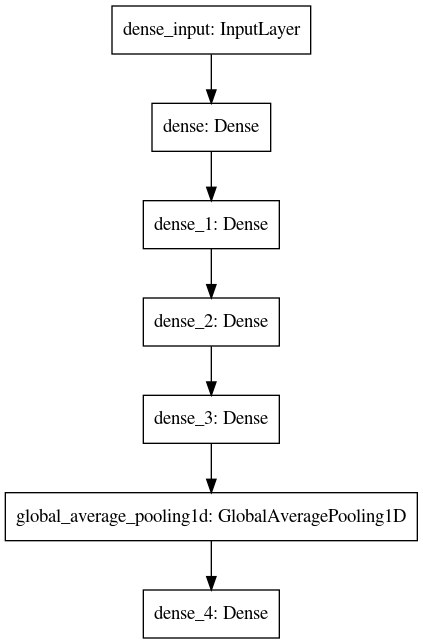

In [20]:
plot_model(ann_model)

In [21]:
batchsize = 10
ann_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 19s 50ms/step - loss: 0.3198 - accuracy: 0.9306 - Recall: 0.1557 - Precision: 0.2383 - AUC: 0.4837 - val_loss: 0.1786 - val_accuracy: 0.9518 - val_Recall: 0.2399 - val_Precision: 0.5880 - val_AUC: 0.5296 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 20s 51ms/step - loss: 0.1764 - accuracy: 0.9481 - Recall: 0.1430 - Precision: 0.5291 - AUC: 0.5367 - val_loss: 0.1720 - val_accuracy: 0.9487 - val_Recall: 0.3334 - val_Precision: 0.5095 - val_AUC: 0.5722 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 23s 60ms/step - loss: 0.1775 - accuracy: 0.9484 - Recall: 0.1644 - Precision: 0.5108 - AUC: 0.5528 - val_loss: 0.1707 - val_accuracy: 0.9480 - val_Recall: 0.0084 - val_Precision: 0.4397 - val_AUC: 0.5732 - lr: 0.0010
Epoch 4/10
388/387 [==============================] - 25s 64ms/step - loss: 0.1672 - accuracy: 0.9496 - Recall: 0.1507 - Precision: 0.5556 - AUC: 0.5664 - val_loss: 0.1621 - val_accuracy:

Text(0, 0.5, 'Accuracy')

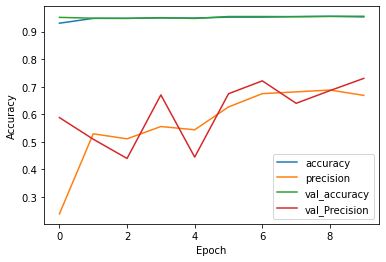

In [22]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

"Accuracy" and "Precision" are overlapping in the graph above.

Text(0, 0.5, 'Loss')

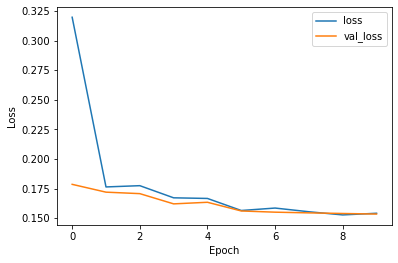

In [23]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

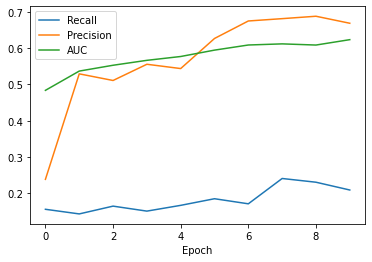

In [24]:
plt.plot(ann_model.history.history['Recall'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [25]:
y_pred = ann_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [26]:
init_thresholds = np.arange(0,1,0.05)

In [27]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.16646496107658282
0.16151299157767104
0.14322134520561455
0.09255054843672307
0.058567135219579194
0.027769265465874514
-0.004744851334372822
-0.05583653994297702
-0.14057744462128782
-0.30972103721727107
-0.6023378070389074
-0.7909154046378458
-0.814285784321912
-0.8166602139870107
-0.8181410813135895
-0.8193413889324968
-0.8212630196259101
-0.8222291208801525
-0.8231691992049878


In [28]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.192217
         Iterations: 663
         Function evaluations: 961


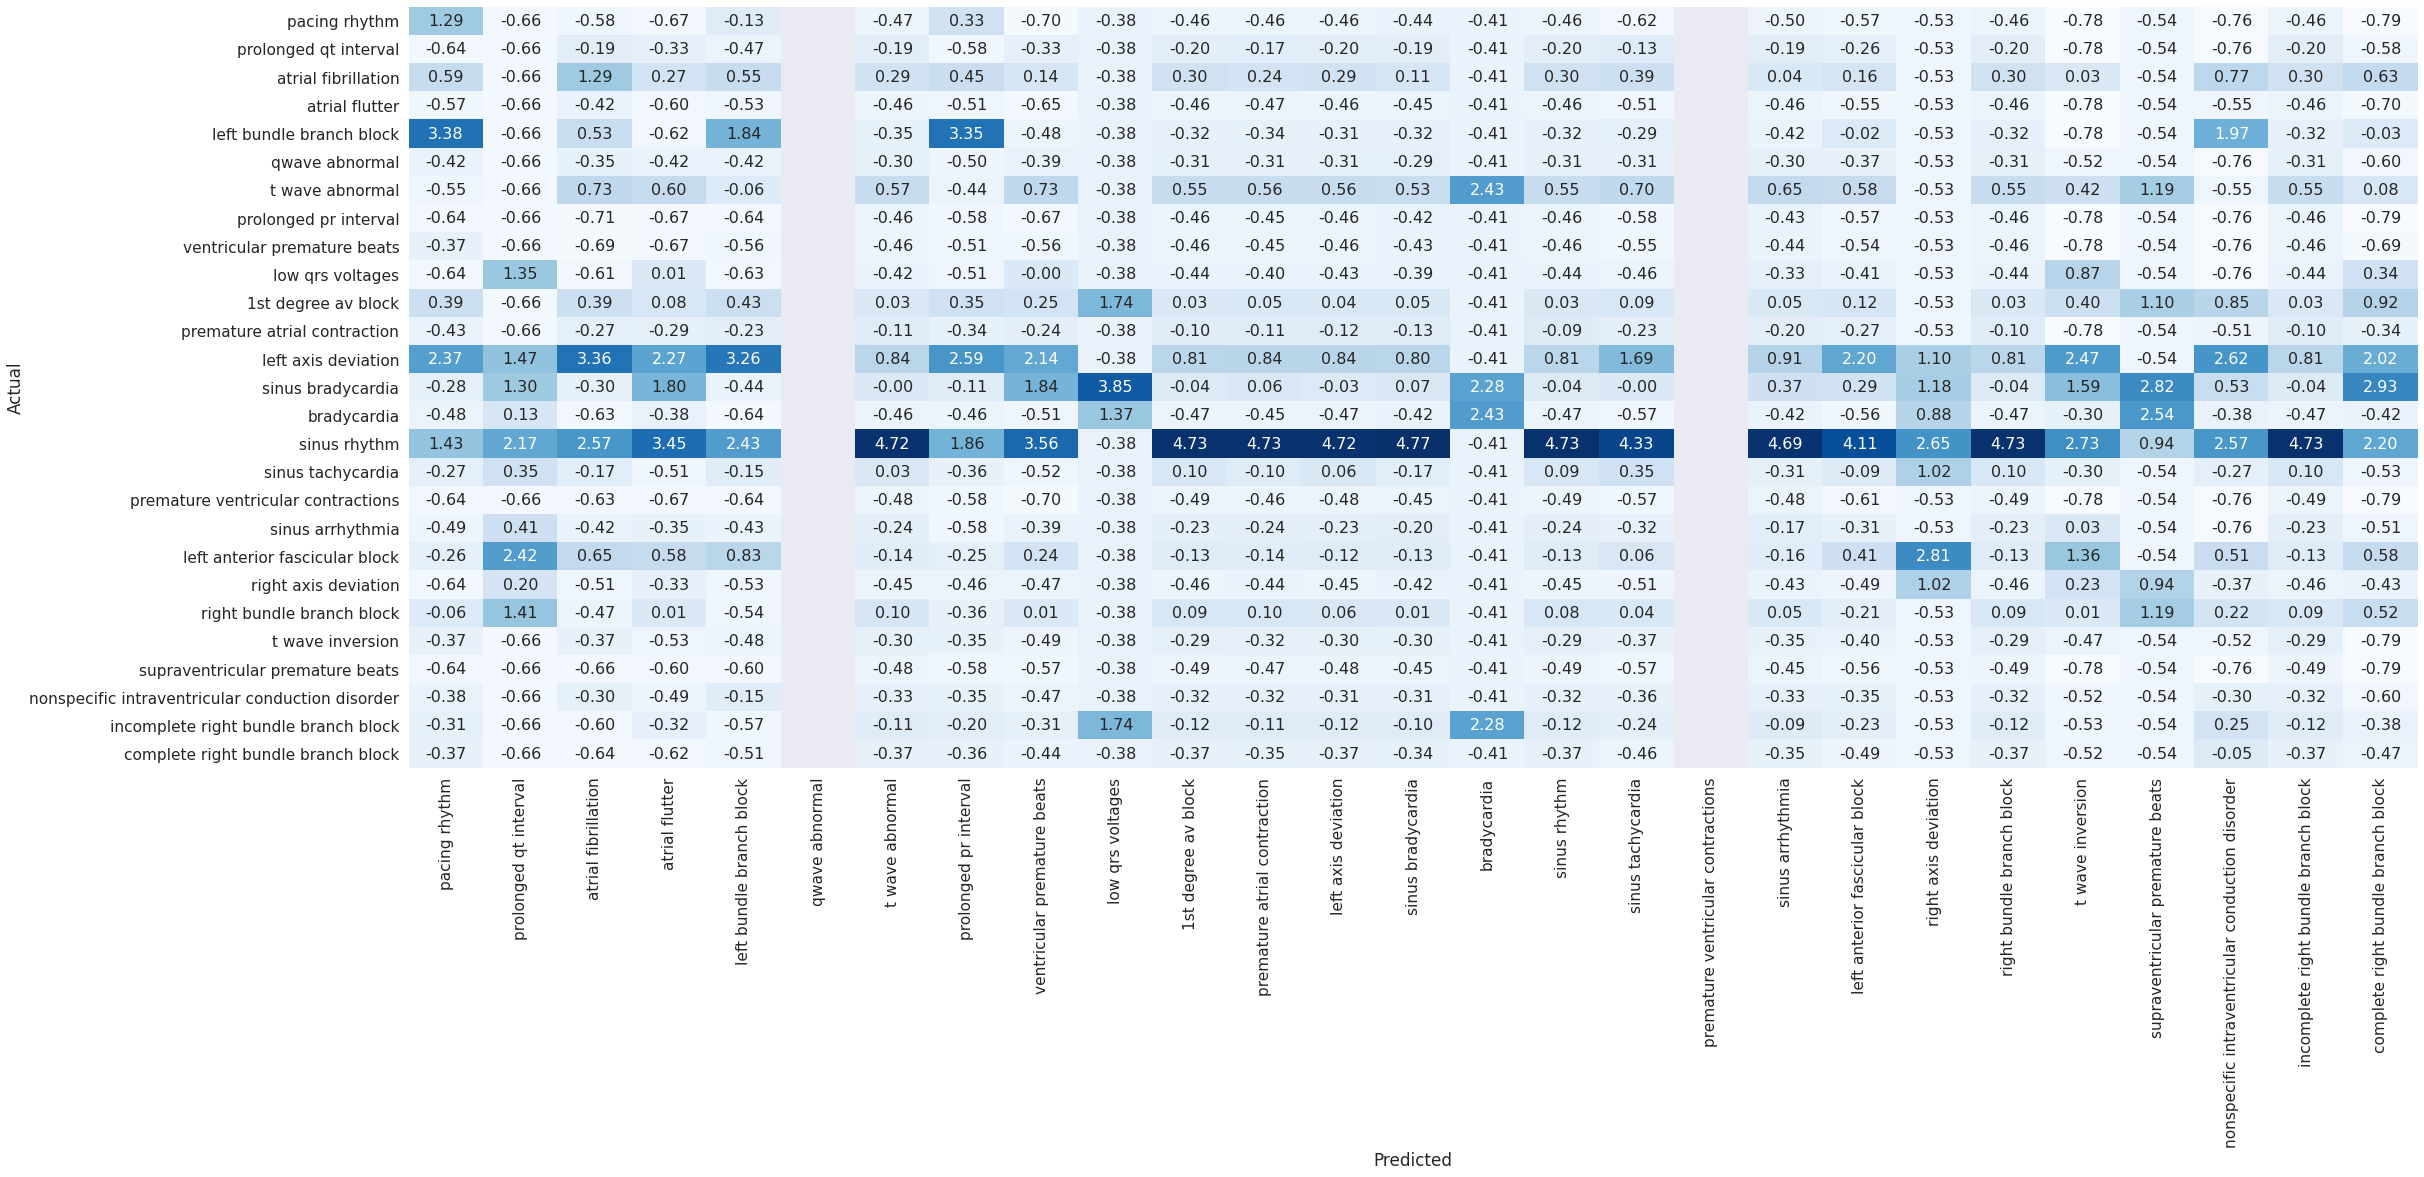

In [29]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_ann.png", dpi=100)

# CNN

# Lenet-5

In [30]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(27, activation = 'sigmoid'))

In [31]:
 lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [32]:
lenet_5_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 6)           24        
_________________________________________________________________
activation (Activation)      (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 6)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2496, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 2496, 16)         

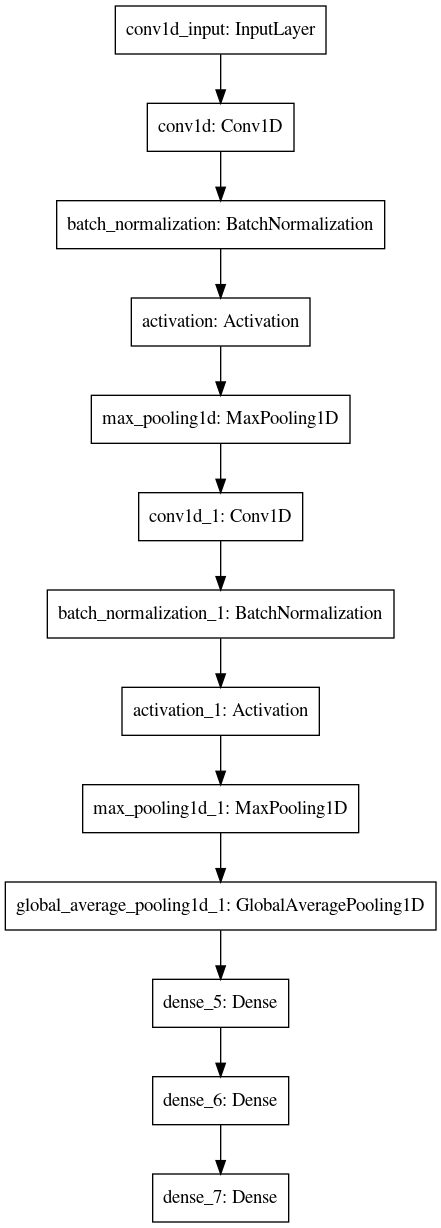

In [33]:
plot_model(lenet_5_model)

In [34]:
batchsize = 10
lenet_5_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 23s 59ms/step - loss: 0.2248 - accuracy: 0.9153 - Recall: 0.2008 - Precision: 0.1978 - AUC: 0.5228 - val_loss: 0.1607 - val_accuracy: 0.9492 - val_Recall: 0.3157 - val_Precision: 0.5185 - val_AUC: 0.5912 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 22s 56ms/step - loss: 0.1555 - accuracy: 0.9498 - Recall: 0.1544 - Precision: 0.5043 - AUC: 0.5756 - val_loss: 0.1576 - val_accuracy: 0.9497 - val_Recall: 0.2950 - val_Precision: 0.5272 - val_AUC: 0.6137 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 21s 55ms/step - loss: 0.1569 - accuracy: 0.9500 - Recall: 0.2145 - Precision: 0.5437 - AUC: 0.5845 - val_loss: 0.1557 - val_accuracy: 0.9501 - val_Recall: 0.2455 - val_Precision: 0.5422 - val_AUC: 0.6285 - lr: 0.0010
Epoch 4/10
388/387 [==============================] - 22s 58ms/step - loss: 0.1555 - accuracy: 0.9496 - Recall: 0.2295 - Precision: 0.5404 - AUC: 0.6018 - val_loss: 0.1525 - val_accuracy:

Text(0, 0.5, 'Accuracy')

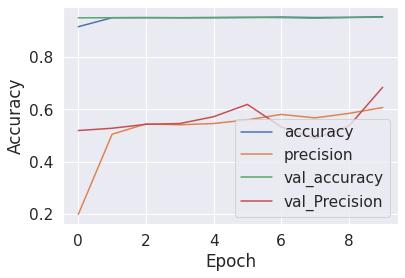

In [35]:
plt.plot(lenet_5_model.history.history['accuracy'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

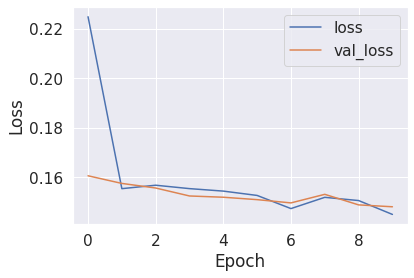

In [36]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

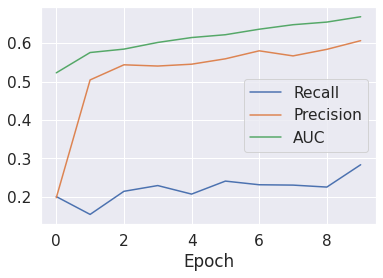

In [37]:
plt.plot(lenet_5_model.history.history['Recall'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [38]:
y_pred = lenet_5_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [39]:
init_thresholds = np.arange(0,1,0.05)

In [40]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.18817838297622003
0.16367001474817922
0.2047337726143261
0.15435635339482118
0.08079146044560127
0.003633219170897834
-0.0665000277539176
-0.15974767702951437
-0.2968479006477987
-0.5156634800272949
-0.703415744155753
-0.7924958096694071
-0.8091651223878094
-0.8126879764563097
-0.8168822221035159
-0.8199602467224619
-0.8225218788359836
-0.8237880569949528
-0.8238661257831744


In [41]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.206443
         Iterations: 77
         Function evaluations: 313


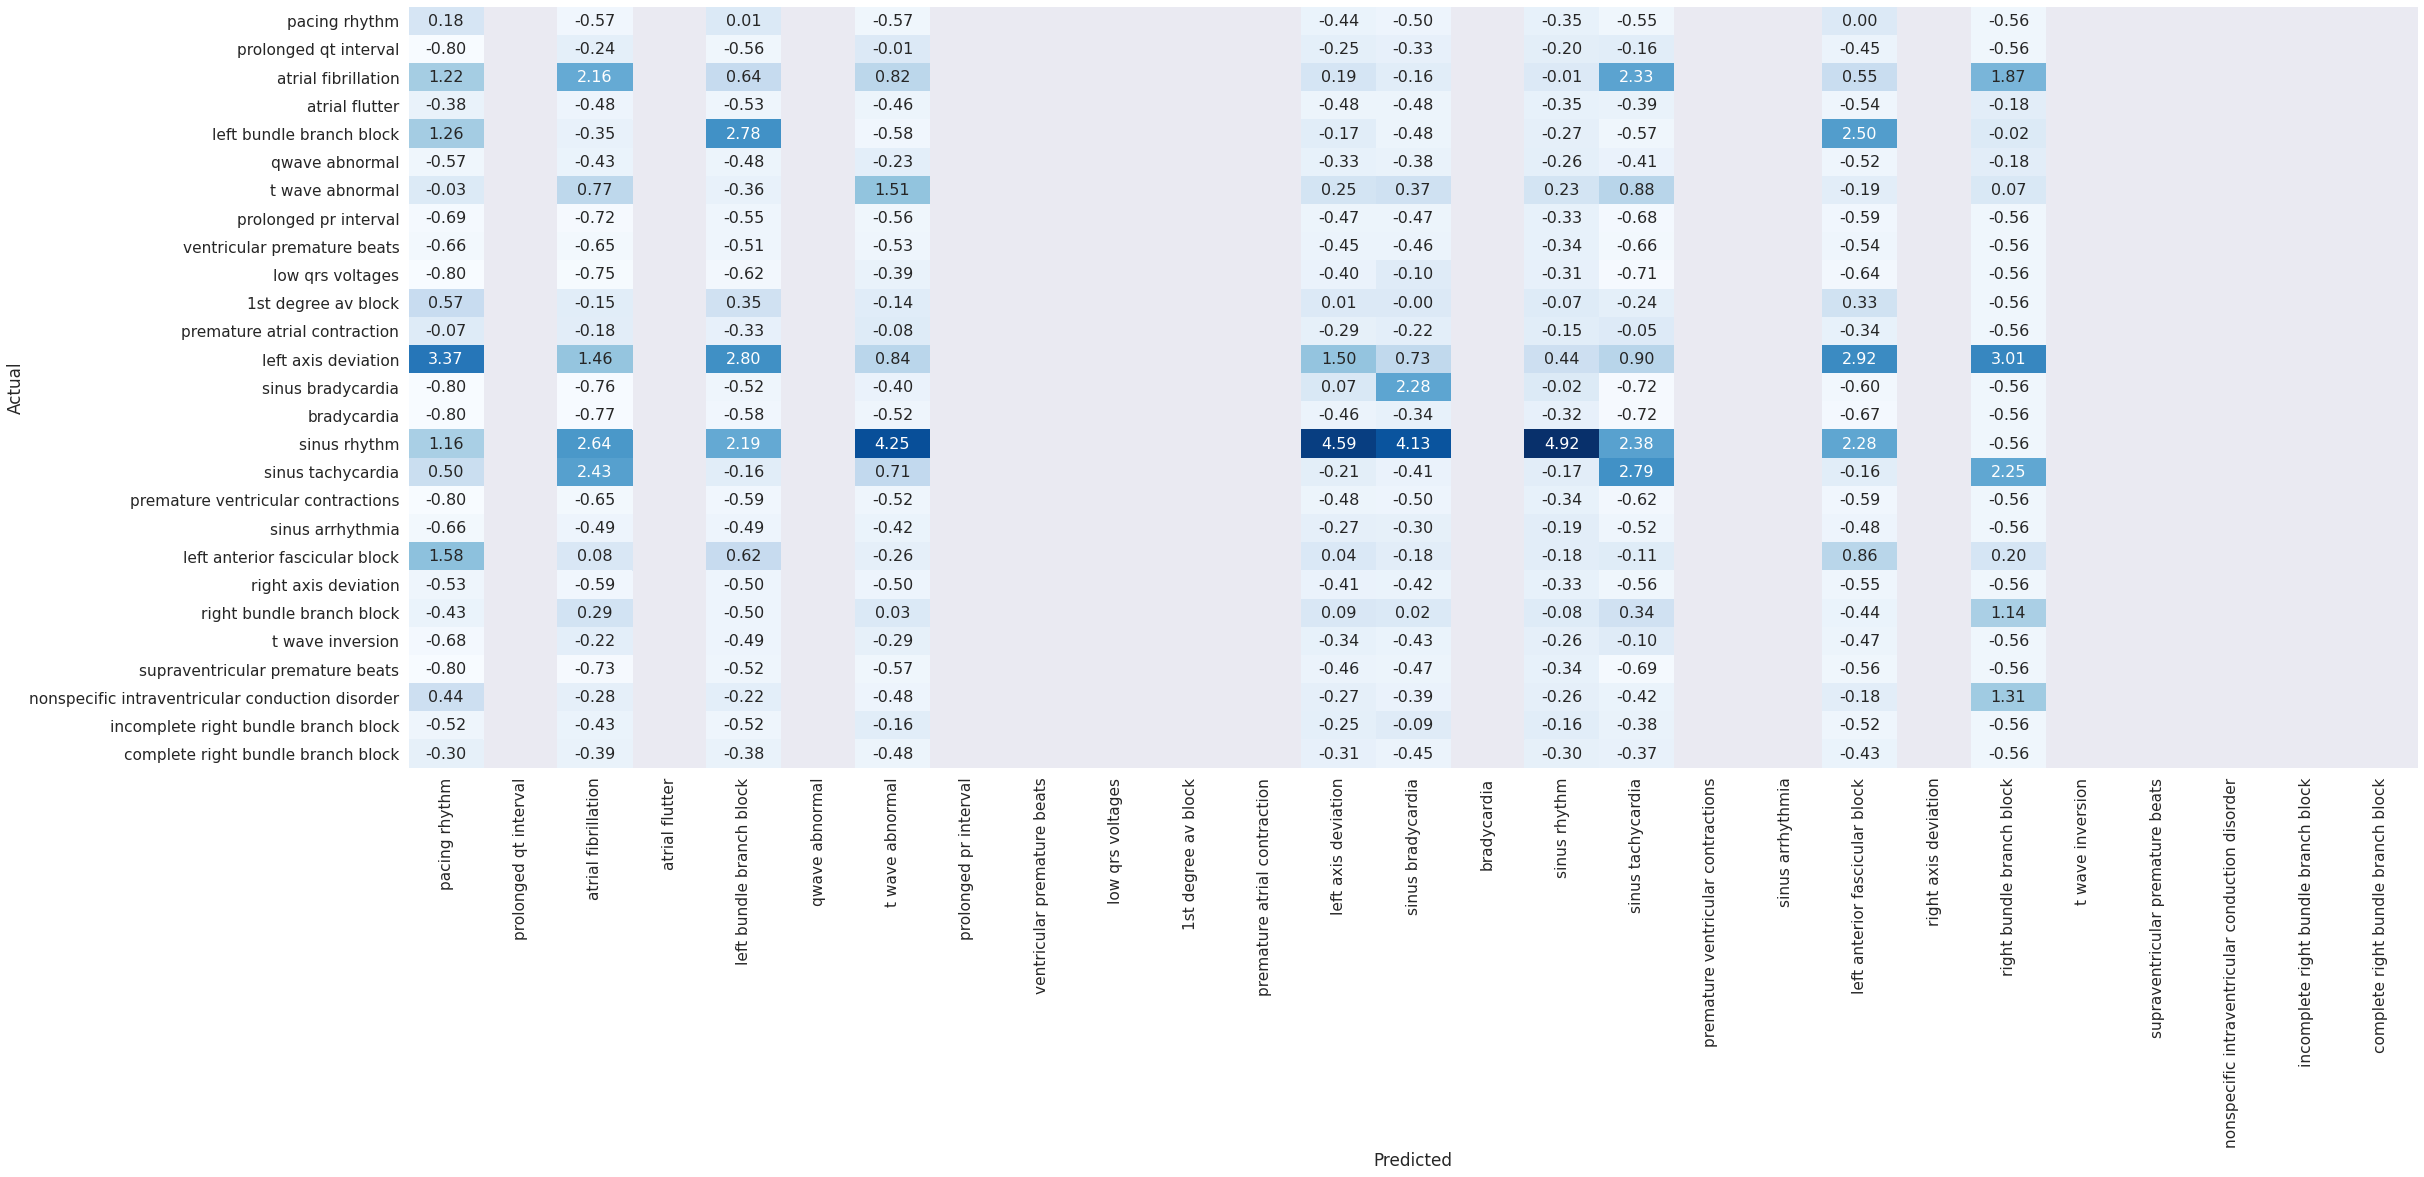

In [42]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_lenet5.png", dpi=100)

# AlexNet

In [43]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(5000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(27, activation='sigmoid'))

In [44]:
 alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [45]:
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1248, 96)          12768     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1248, 96)          384       
_________________________________________________________________
activation_2 (Activation)    (None, 1248, 96)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 624, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 624, 256)          123136    
_________________________________________________________________
batch_normalization_3 (Batch (None, 624, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 624, 256)         

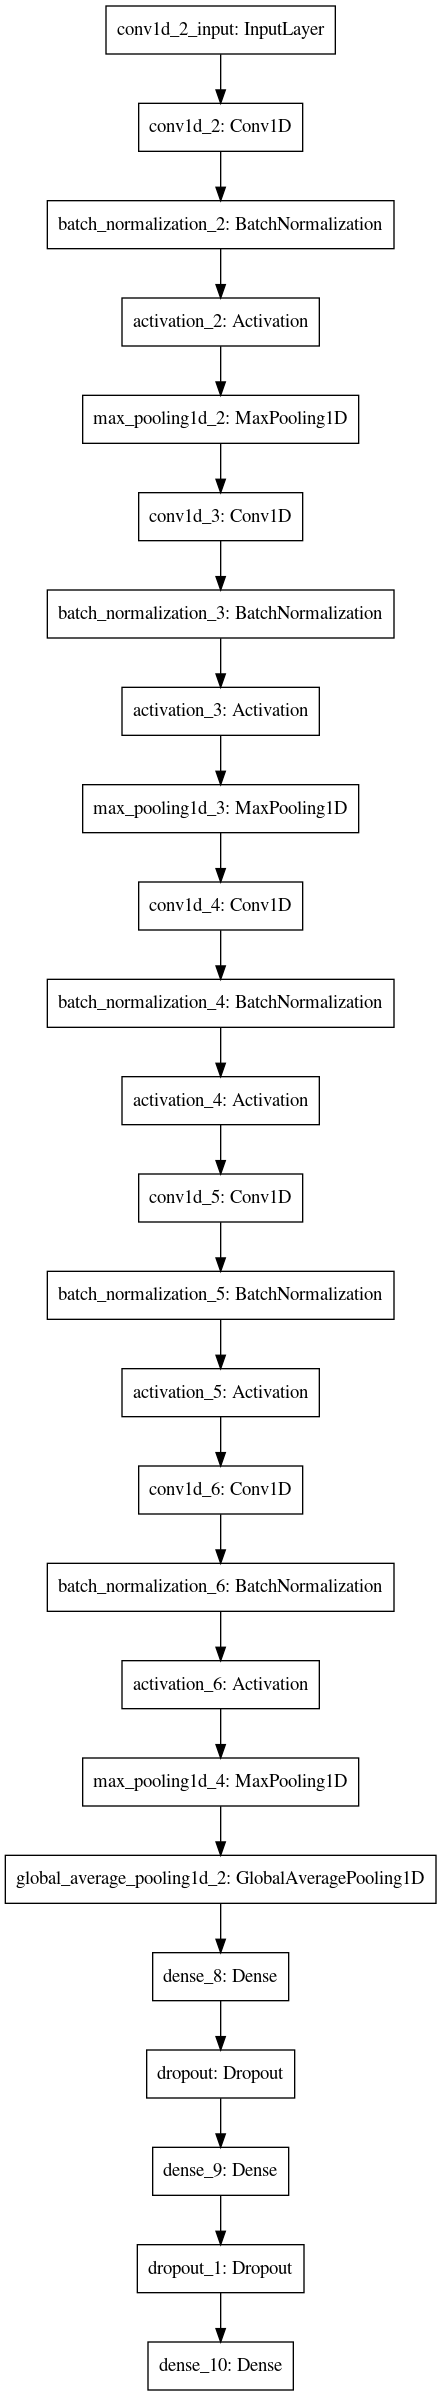

In [46]:
plot_model(alexNet_model)

In [47]:
batchsize = 10
alexNet_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), callbacks=[reduce_lr,early_stop])

Epoch 1/10
388/387 [==============================] - 21s 54ms/step - loss: 0.1882 - accuracy: 0.9422 - Recall: 0.2002 - Precision: 0.3799 - AUC: 0.5741 - val_loss: 0.1519 - val_accuracy: 0.9547 - val_Recall: 0.2842 - val_Precision: 0.6459 - val_AUC: 0.6759 - lr: 0.0010
Epoch 2/10
388/387 [==============================] - 19s 50ms/step - loss: 0.1582 - accuracy: 0.9528 - Recall: 0.2256 - Precision: 0.6323 - AUC: 0.6333 - val_loss: 0.1538 - val_accuracy: 0.9526 - val_Recall: 0.3299 - val_Precision: 0.5756 - val_AUC: 0.6816 - lr: 0.0010
Epoch 3/10
388/387 [==============================] - 19s 48ms/step - loss: 0.1519 - accuracy: 0.9540 - Recall: 0.2581 - Precision: 0.6498 - AUC: 0.6550 - val_loss: 0.1431 - val_accuracy: 0.9551 - val_Recall: 0.1934 - val_Precision: 0.7681 - val_AUC: 0.7473 - lr: 0.0010
Epoch 4/10
388/387 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9558 - Recall: 0.2698 - Precision: 0.6651 - AUC: 0.6582
Epoch 00004: ReduceLROnPlateau reducing 

Text(0, 0.5, 'Accuracy')

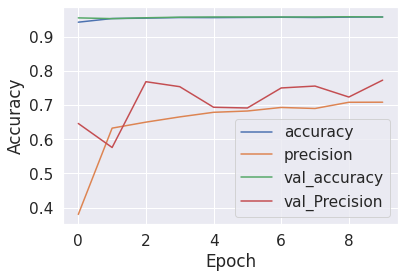

In [48]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

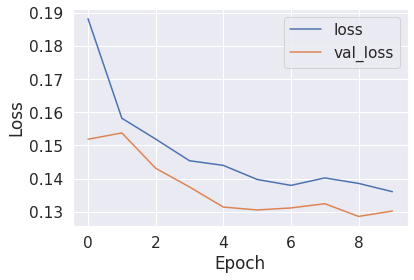

In [49]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

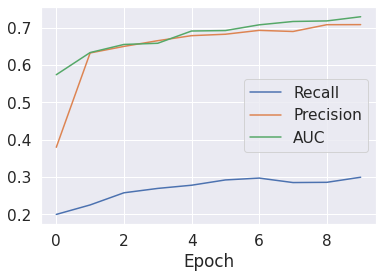

In [50]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [51]:
y_pred = alexNet_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [52]:
init_thresholds = np.arange(0,1,0.05)

In [53]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.25539865770548115
0.3073972992822328
0.3124812355123081
0.2556020106151725
0.16248758944423702
0.043929016697823585
-0.06811457626294588
-0.1501915810386413
-0.21541286062929654
-0.28621645356869035
-0.36166384987817907
-0.4358724618088511
-0.5043928679793802
-0.5731952163257056
-0.6430205910843515
-0.7051031684845014
-0.7714640781225045
-0.814097768656945
-0.8238661257831744


In [54]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.314743
         Iterations: 56
         Function evaluations: 291


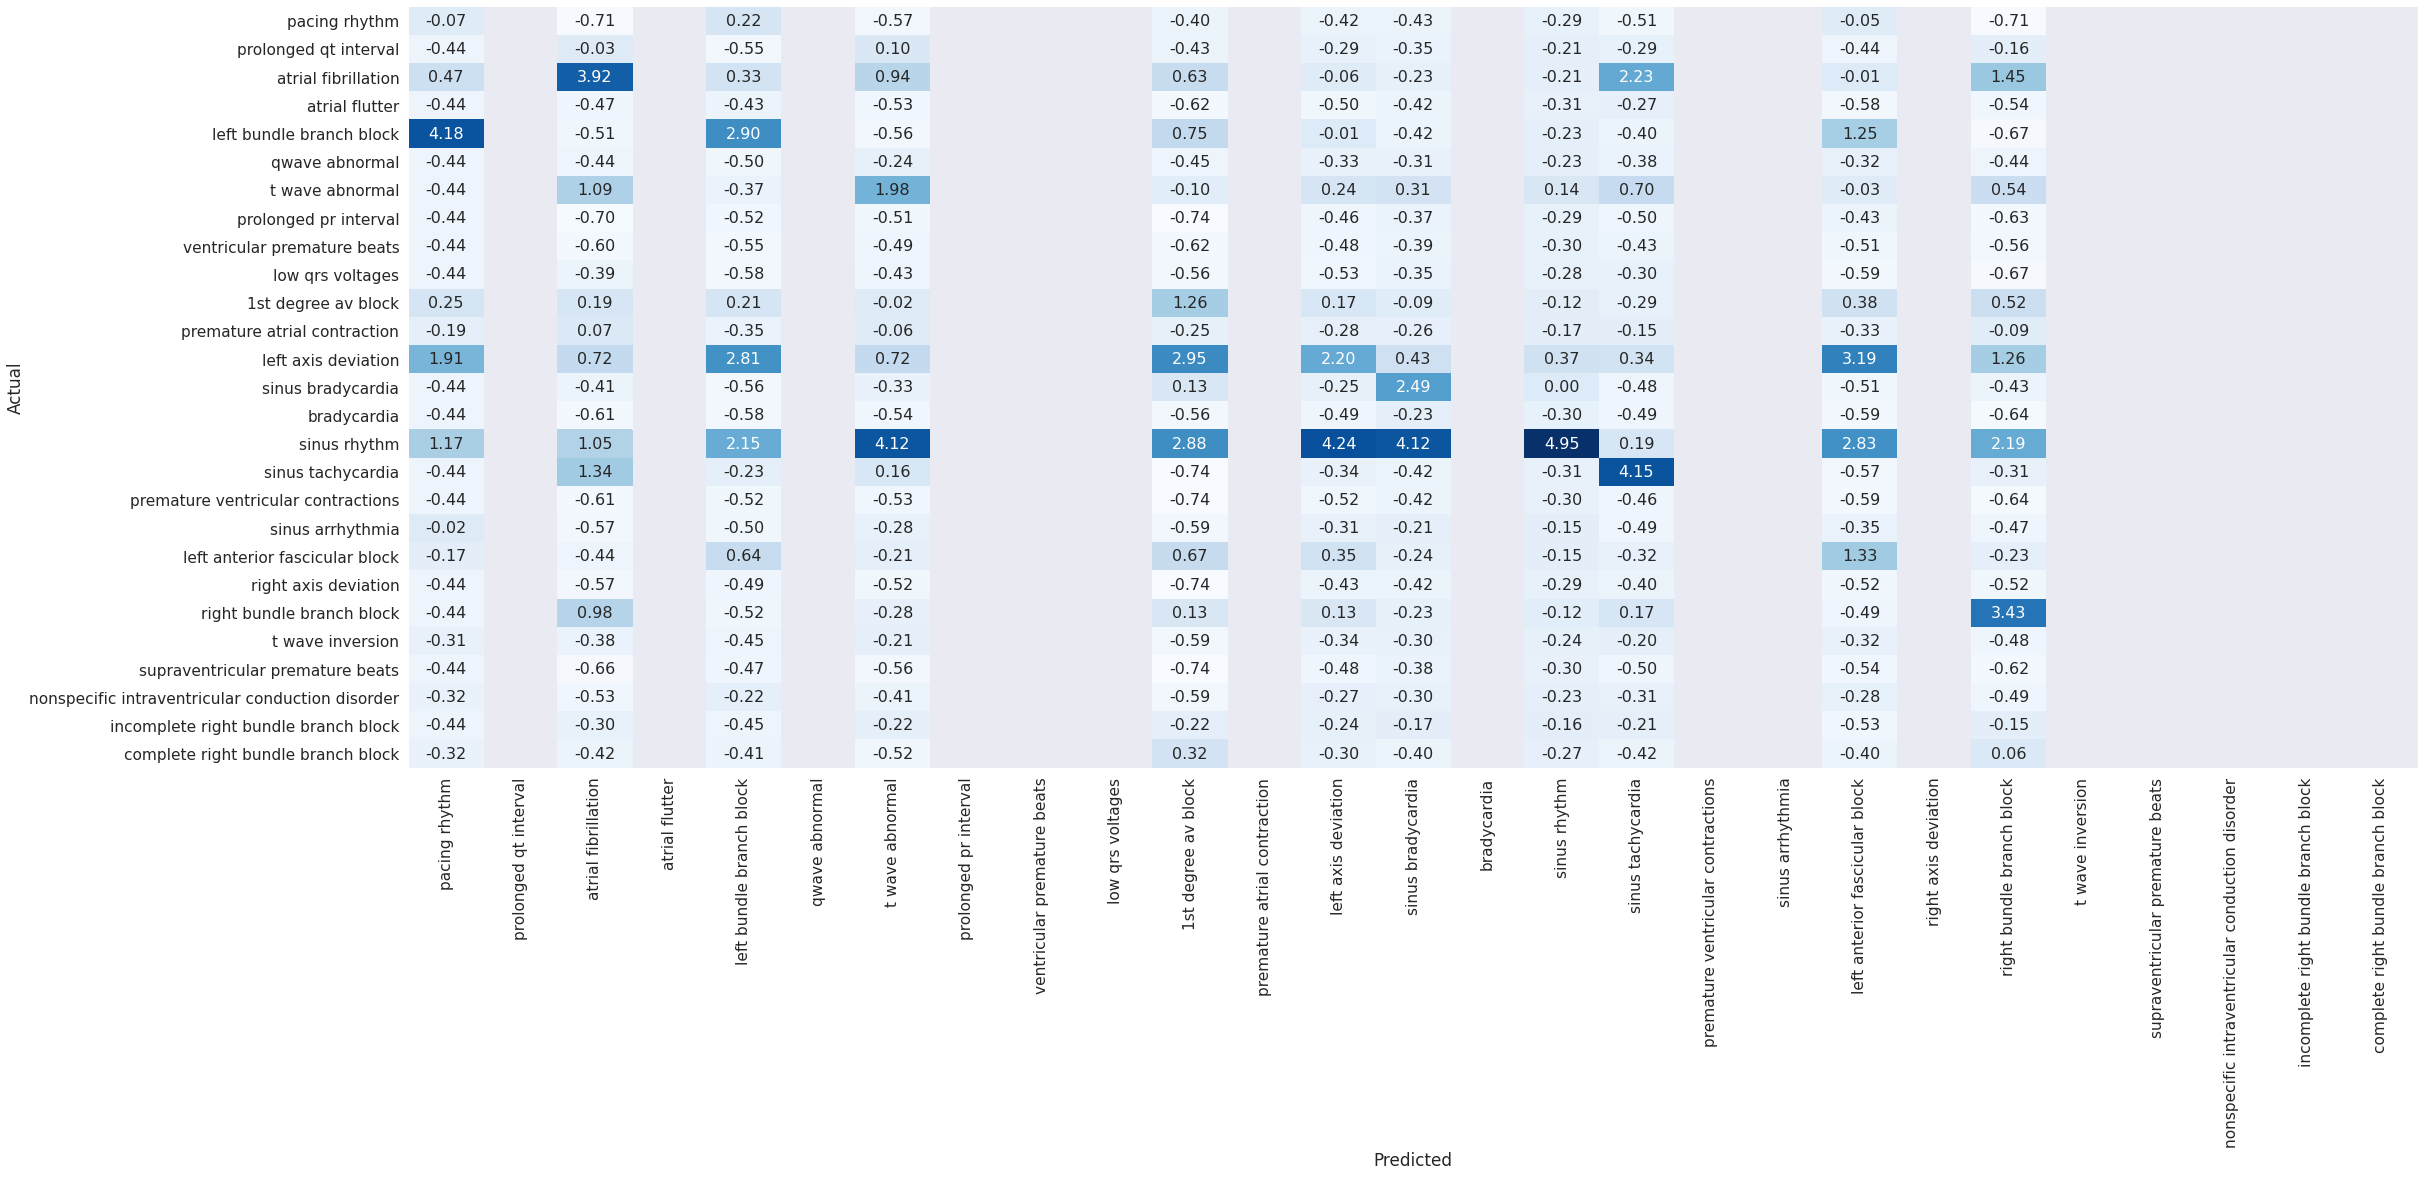

In [55]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_alexnet.png", dpi=100)

# VGG-16

In [56]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(5000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(27, activation='sigmoid'))

In [57]:
 vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [58]:
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 5000, 64)          2368      
_________________________________________________________________
batch_normalization_7 (Batch (None, 5000, 64)          256       
_________________________________________________________________
activation_7 (Activation)    (None, 5000, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 5000, 64)          12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 5000, 64)          256       
_________________________________________________________________
activation_8 (Activation)    (None, 5000, 64)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2500, 64)         

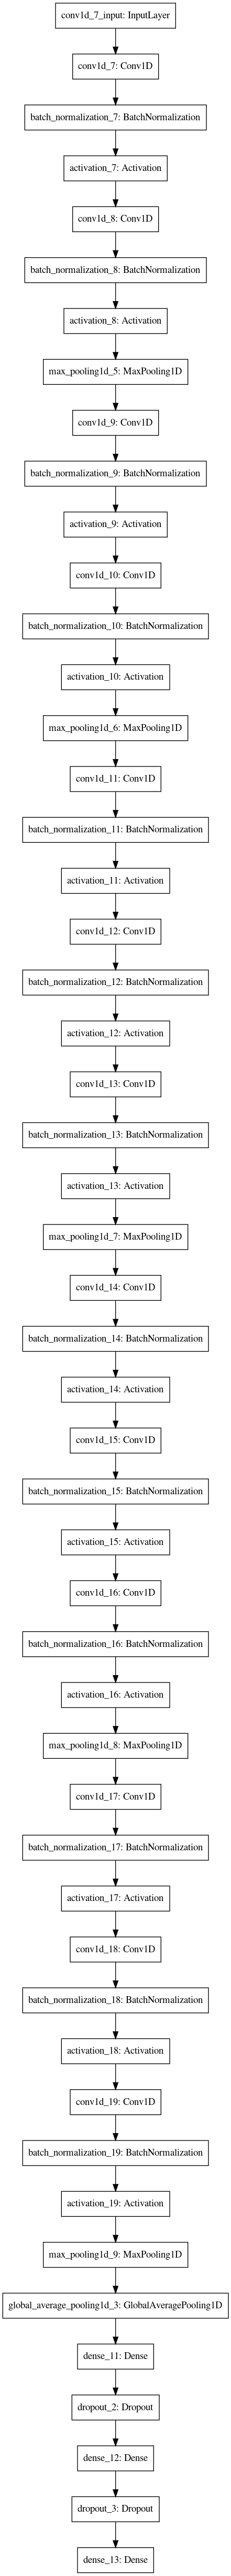

In [59]:
plot_model(vgg_16_model)

In [60]:
batchsize = 10
vgg_16_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 34s 88ms/step - loss: 0.1899 - accuracy: 0.9433 - Recall: 0.2076 - Precision: 0.4052 - AUC: 0.5614 - val_loss: 0.2311 - val_accuracy: 0.9492 - val_Recall: 0.3306 - val_Precision: 0.5172 - val_AUC: 0.6163
Epoch 2/10
388/387 [==============================] - 32s 81ms/step - loss: 0.1598 - accuracy: 0.9536 - Recall: 0.2204 - Precision: 0.6494 - AUC: 0.6185 - val_loss: 0.1493 - val_accuracy: 0.9553 - val_Recall: 0.3006 - val_Precision: 0.6501 - val_AUC: 0.6883
Epoch 3/10
388/387 [==============================] - 32s 82ms/step - loss: 0.1529 - accuracy: 0.9536 - Recall: 0.2361 - Precision: 0.6395 - AUC: 0.6483 - val_loss: 0.2064 - val_accuracy: 0.9507 - val_Recall: 0.3410 - val_Precision: 0.5405 - val_AUC: 0.6277
Epoch 4/10
388/387 [==============================] - 31s 80ms/step - loss: 0.1508 - accuracy: 0.9548 - Recall: 0.2641 - Precision: 0.6665 - AUC: 0.6510 - val_loss: 0.1672 - val_accuracy: 0.9527 - val_Recall: 0.3393 - val_Prec

Text(0, 0.5, 'Accuracy')

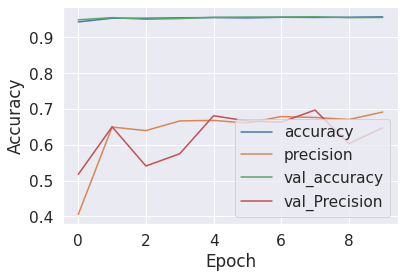

In [61]:
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

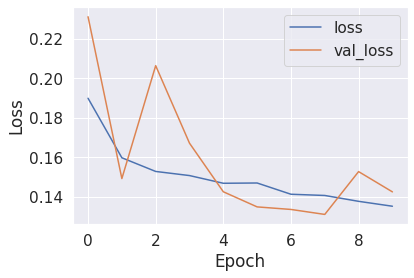

In [62]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

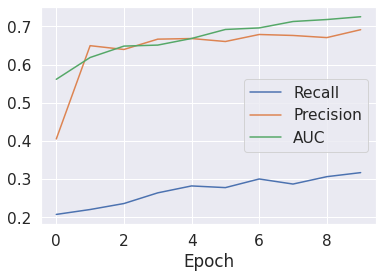

In [63]:
plt.plot(vgg_16_model.history.history['Recall'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [64]:
y_pred = vgg_16_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [65]:
init_thresholds = np.arange(0,1,0.05)

In [66]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.2821097813980938
0.2892430234882396
0.24375326937253713
0.1692181490632291
0.1065518428915838
0.06294254227802588
0.02077739226408657
-0.023828662058732124
-0.06057499010141034
-0.09254180055018323
-0.13118422428679372
-0.16755215105418092
-0.2126633057898416
-0.26585913411908574
-0.3259582763684803
-0.41977784922207595
-0.5457355772502602
-0.6988736044710343
-0.7802890227360683


In [67]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.295357
         Iterations: 183
         Function evaluations: 407


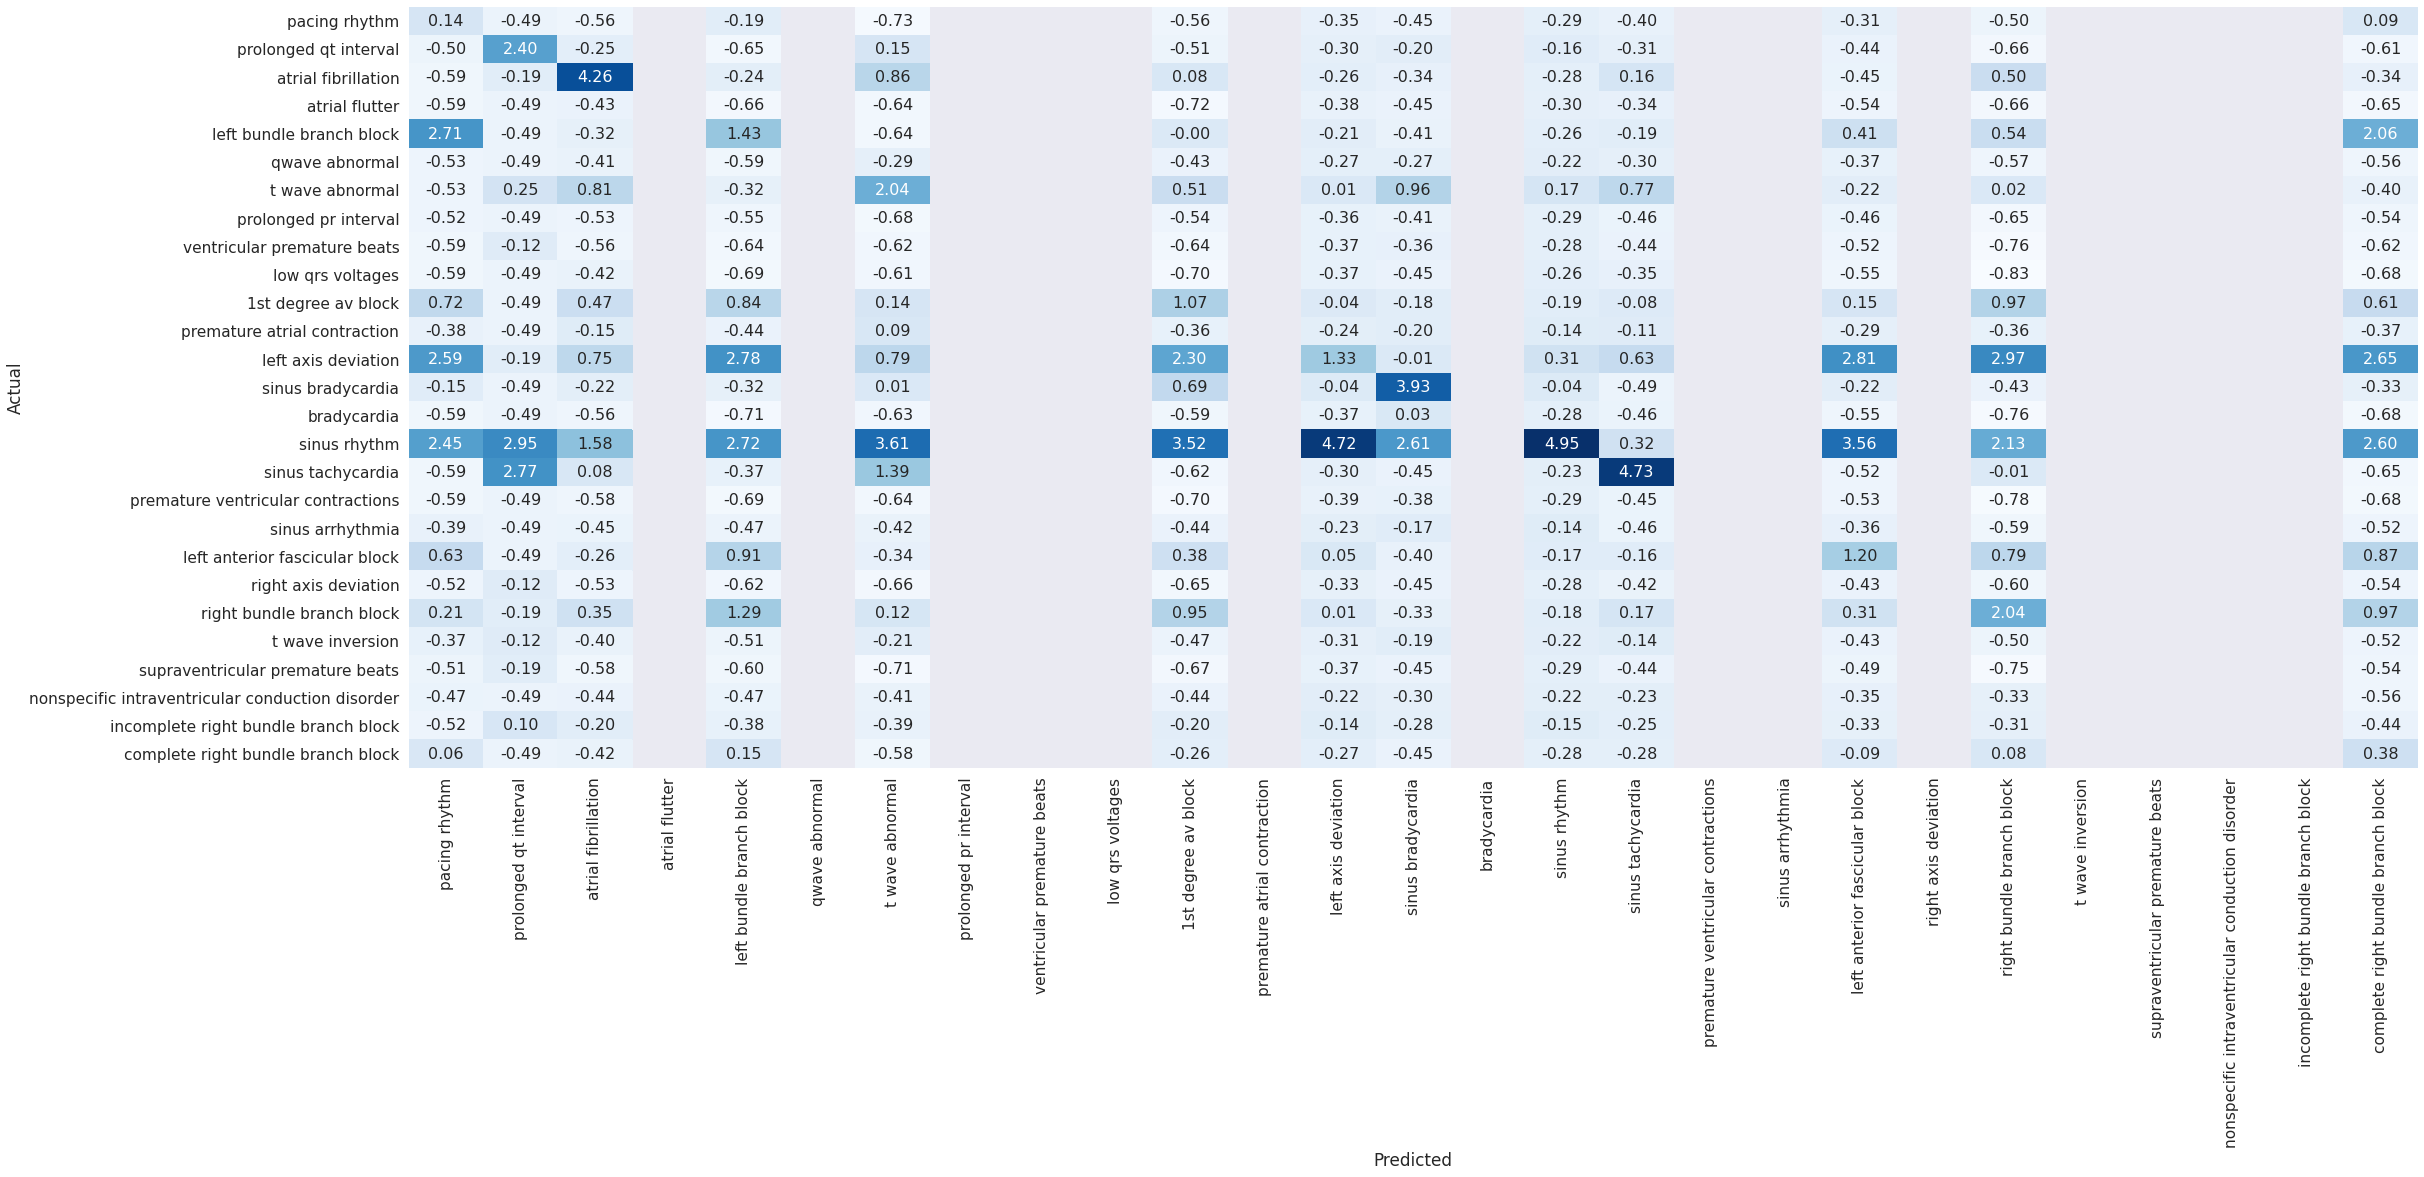

In [68]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_vgg16.png", dpi=100)

# ResNet50

In [69]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [70]:
resNet50_model = ResNet50(input_shape = (5000,12))

In [71]:
 resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [72]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 5006, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 2500, 64)     5440        zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 2500, 64)     256         conv1d_20[0][0]                  
___________________________________________________________________________________________

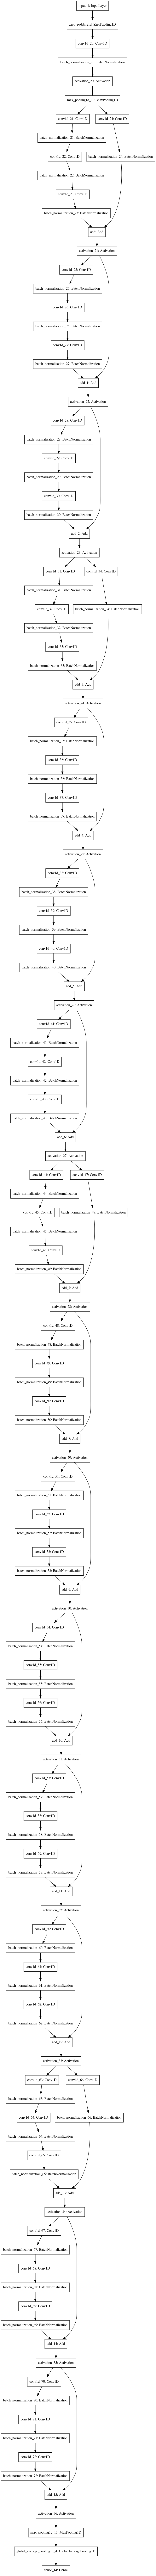

In [73]:
plot_model(resNet50_model)

In [74]:
batchsize = 10
resNet50_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 58s 149ms/step - loss: 0.1932 - accuracy: 0.9459 - Recall: 0.2063 - Precision: 0.4693 - AUC: 0.5448 - val_loss: 0.3601 - val_accuracy: 0.9373 - val_Recall: 0.0882 - val_Precision: 0.2298 - val_AUC: 0.5780
Epoch 2/10
388/387 [==============================] - 57s 148ms/step - loss: 0.1660 - accuracy: 0.9506 - Recall: 0.2374 - Precision: 0.5716 - AUC: 0.5992 - val_loss: 0.4059 - val_accuracy: 0.9412 - val_Recall: 0.1282 - val_Precision: 0.3298 - val_AUC: 0.6504
Epoch 3/10
388/387 [==============================] - 57s 148ms/step - loss: 0.1573 - accuracy: 0.9526 - Recall: 0.2523 - Precision: 0.6051 - AUC: 0.6455 - val_loss: 0.3338 - val_accuracy: 0.9486 - val_Recall: 0.1595 - val_Precision: 0.5158 - val_AUC: 0.6197
Epoch 4/10
388/387 [==============================] - 56s 145ms/step - loss: 0.1513 - accuracy: 0.9534 - Recall: 0.2747 - Precision: 0.6320 - AUC: 0.6840 - val_loss: 0.2023 - val_accuracy: 0.9519 - val_Recall: 0.1461 - val_

Text(0, 0.5, 'Accuracy')

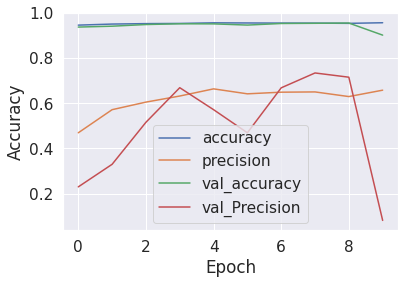

In [75]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

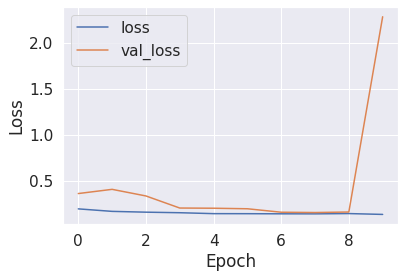

In [76]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

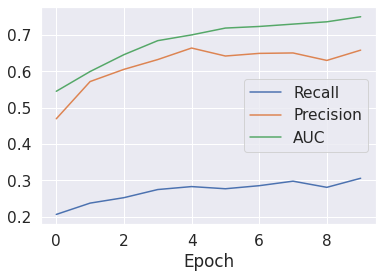

In [77]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [78]:
y_pred = resNet50_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [79]:
init_thresholds = np.arange(0,1,0.05)

In [80]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.14865090446744605
0.020996714829765232
-0.03366338346364113
-0.08691144933845596
-0.13320414962561644
-0.18526433266857822
-0.22723032595089818
-0.27141391427912154
-0.31432766497392806
-0.3562738970942296
-0.39101404315767935
-0.41595362871975844
-0.442311347760738
-0.45968523129284045
-0.47913323523773055
-0.4929256550232704
-0.5116581678180129
-0.5238326700545558
-0.536342298828871
-0.5510447776313943


In [81]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.206532
         Iterations: 638
         Function evaluations: 928


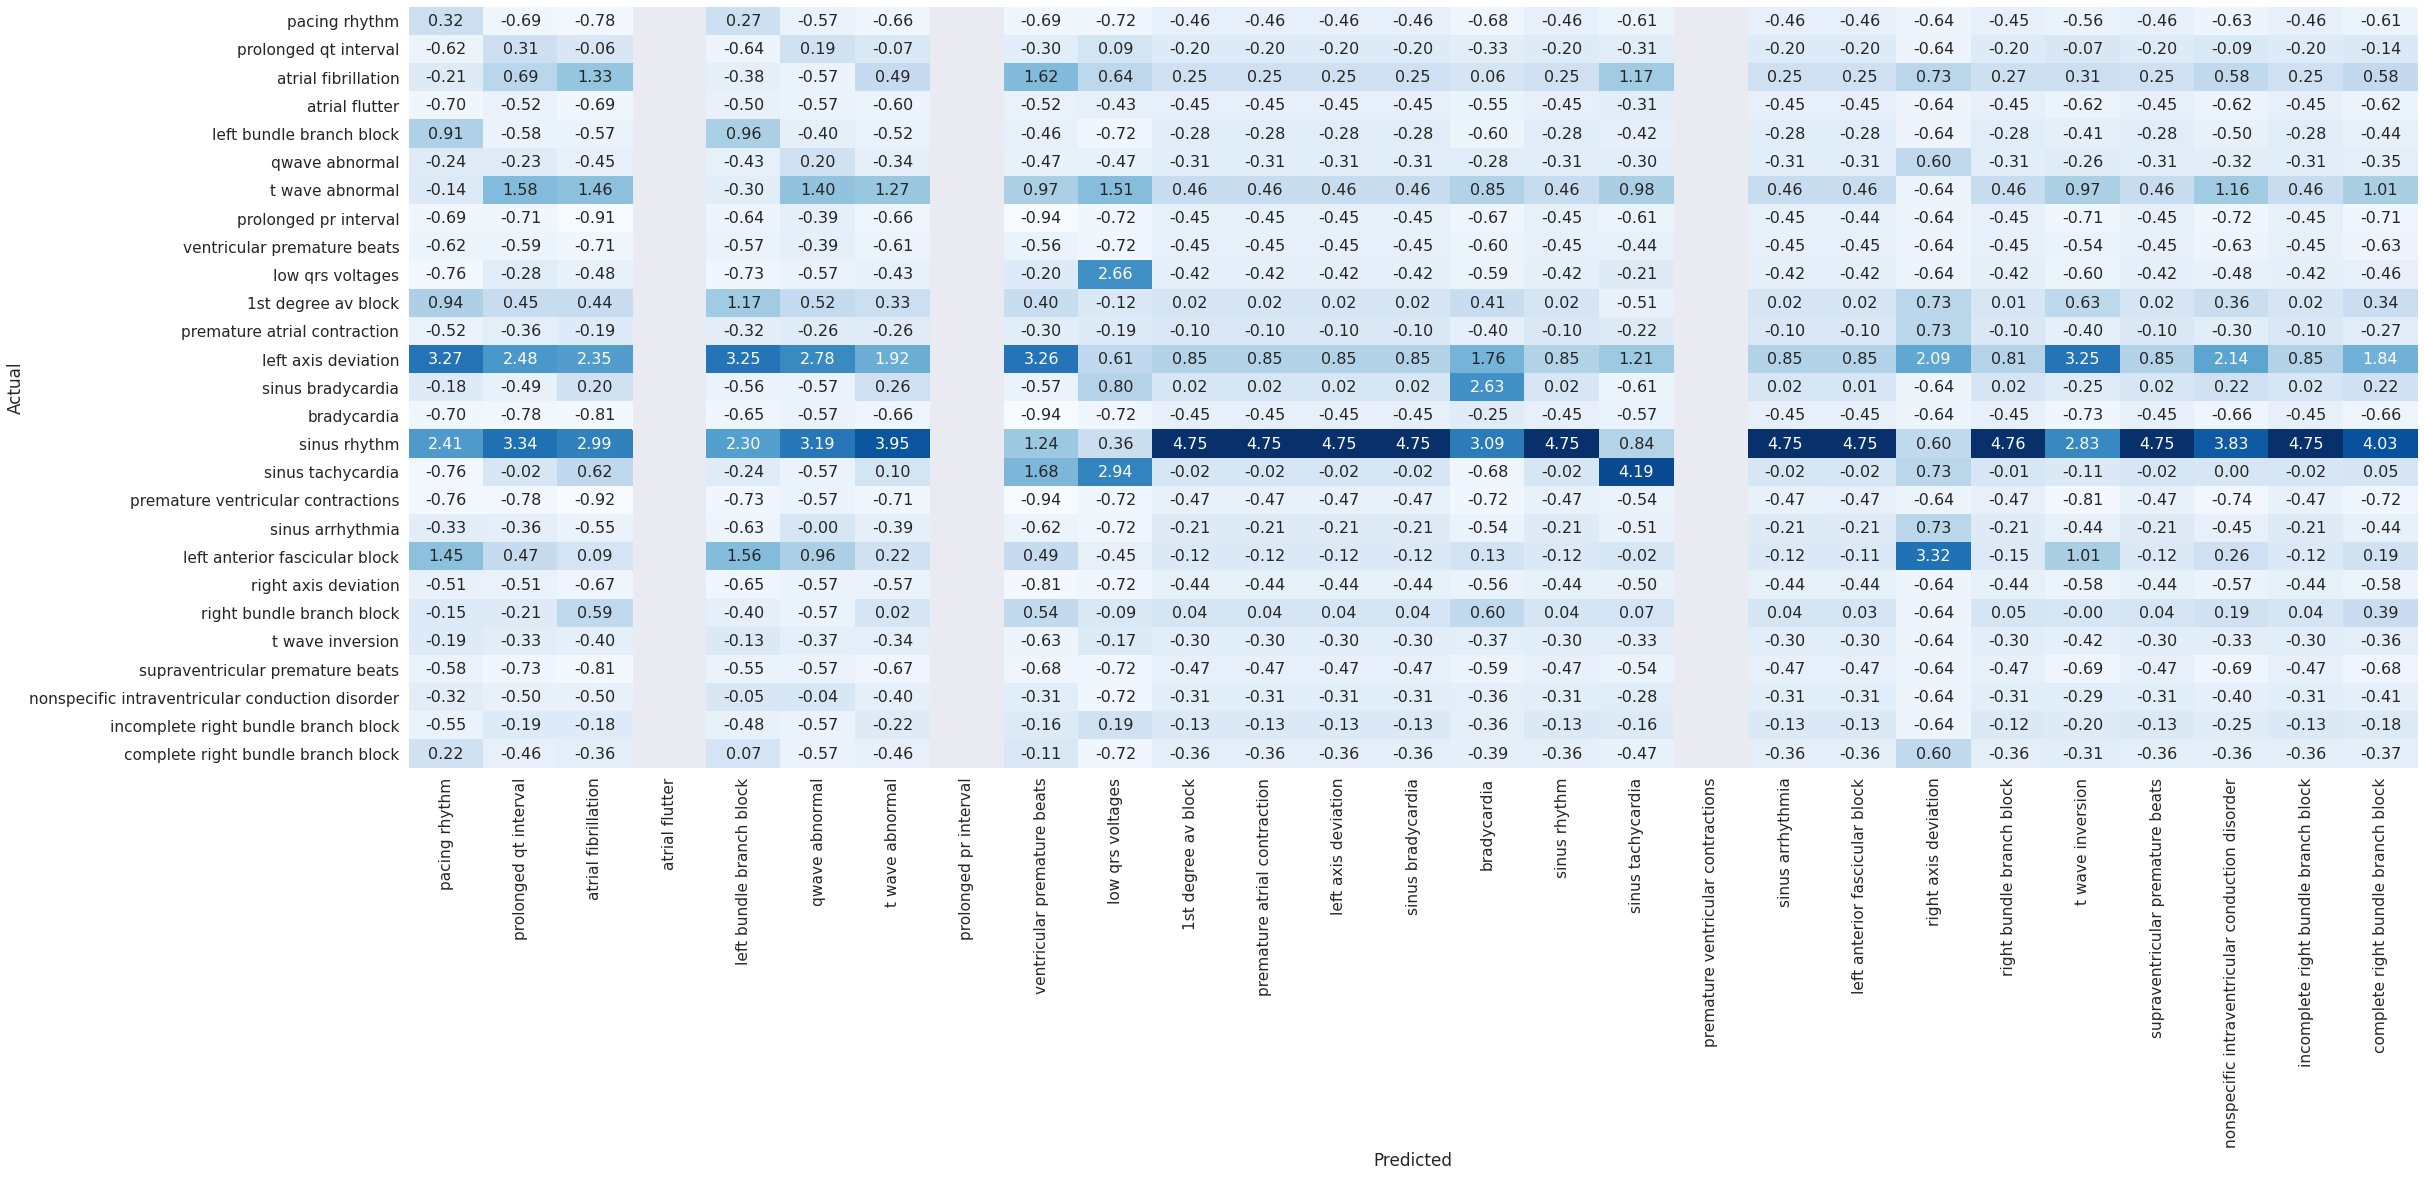

In [82]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_resnet50.png", dpi=100)

# Inception

In [83]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(27,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [84]:
inception_model = inception_model(input_shape = (5000,12))

In [85]:
 inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [86]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 5006, 12)     0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_73 (Conv1D)              (None, 5006, 64)     5440        zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 5006, 64)     256         conv1d_73[0][0]                  
__________________________________________________________________________________________

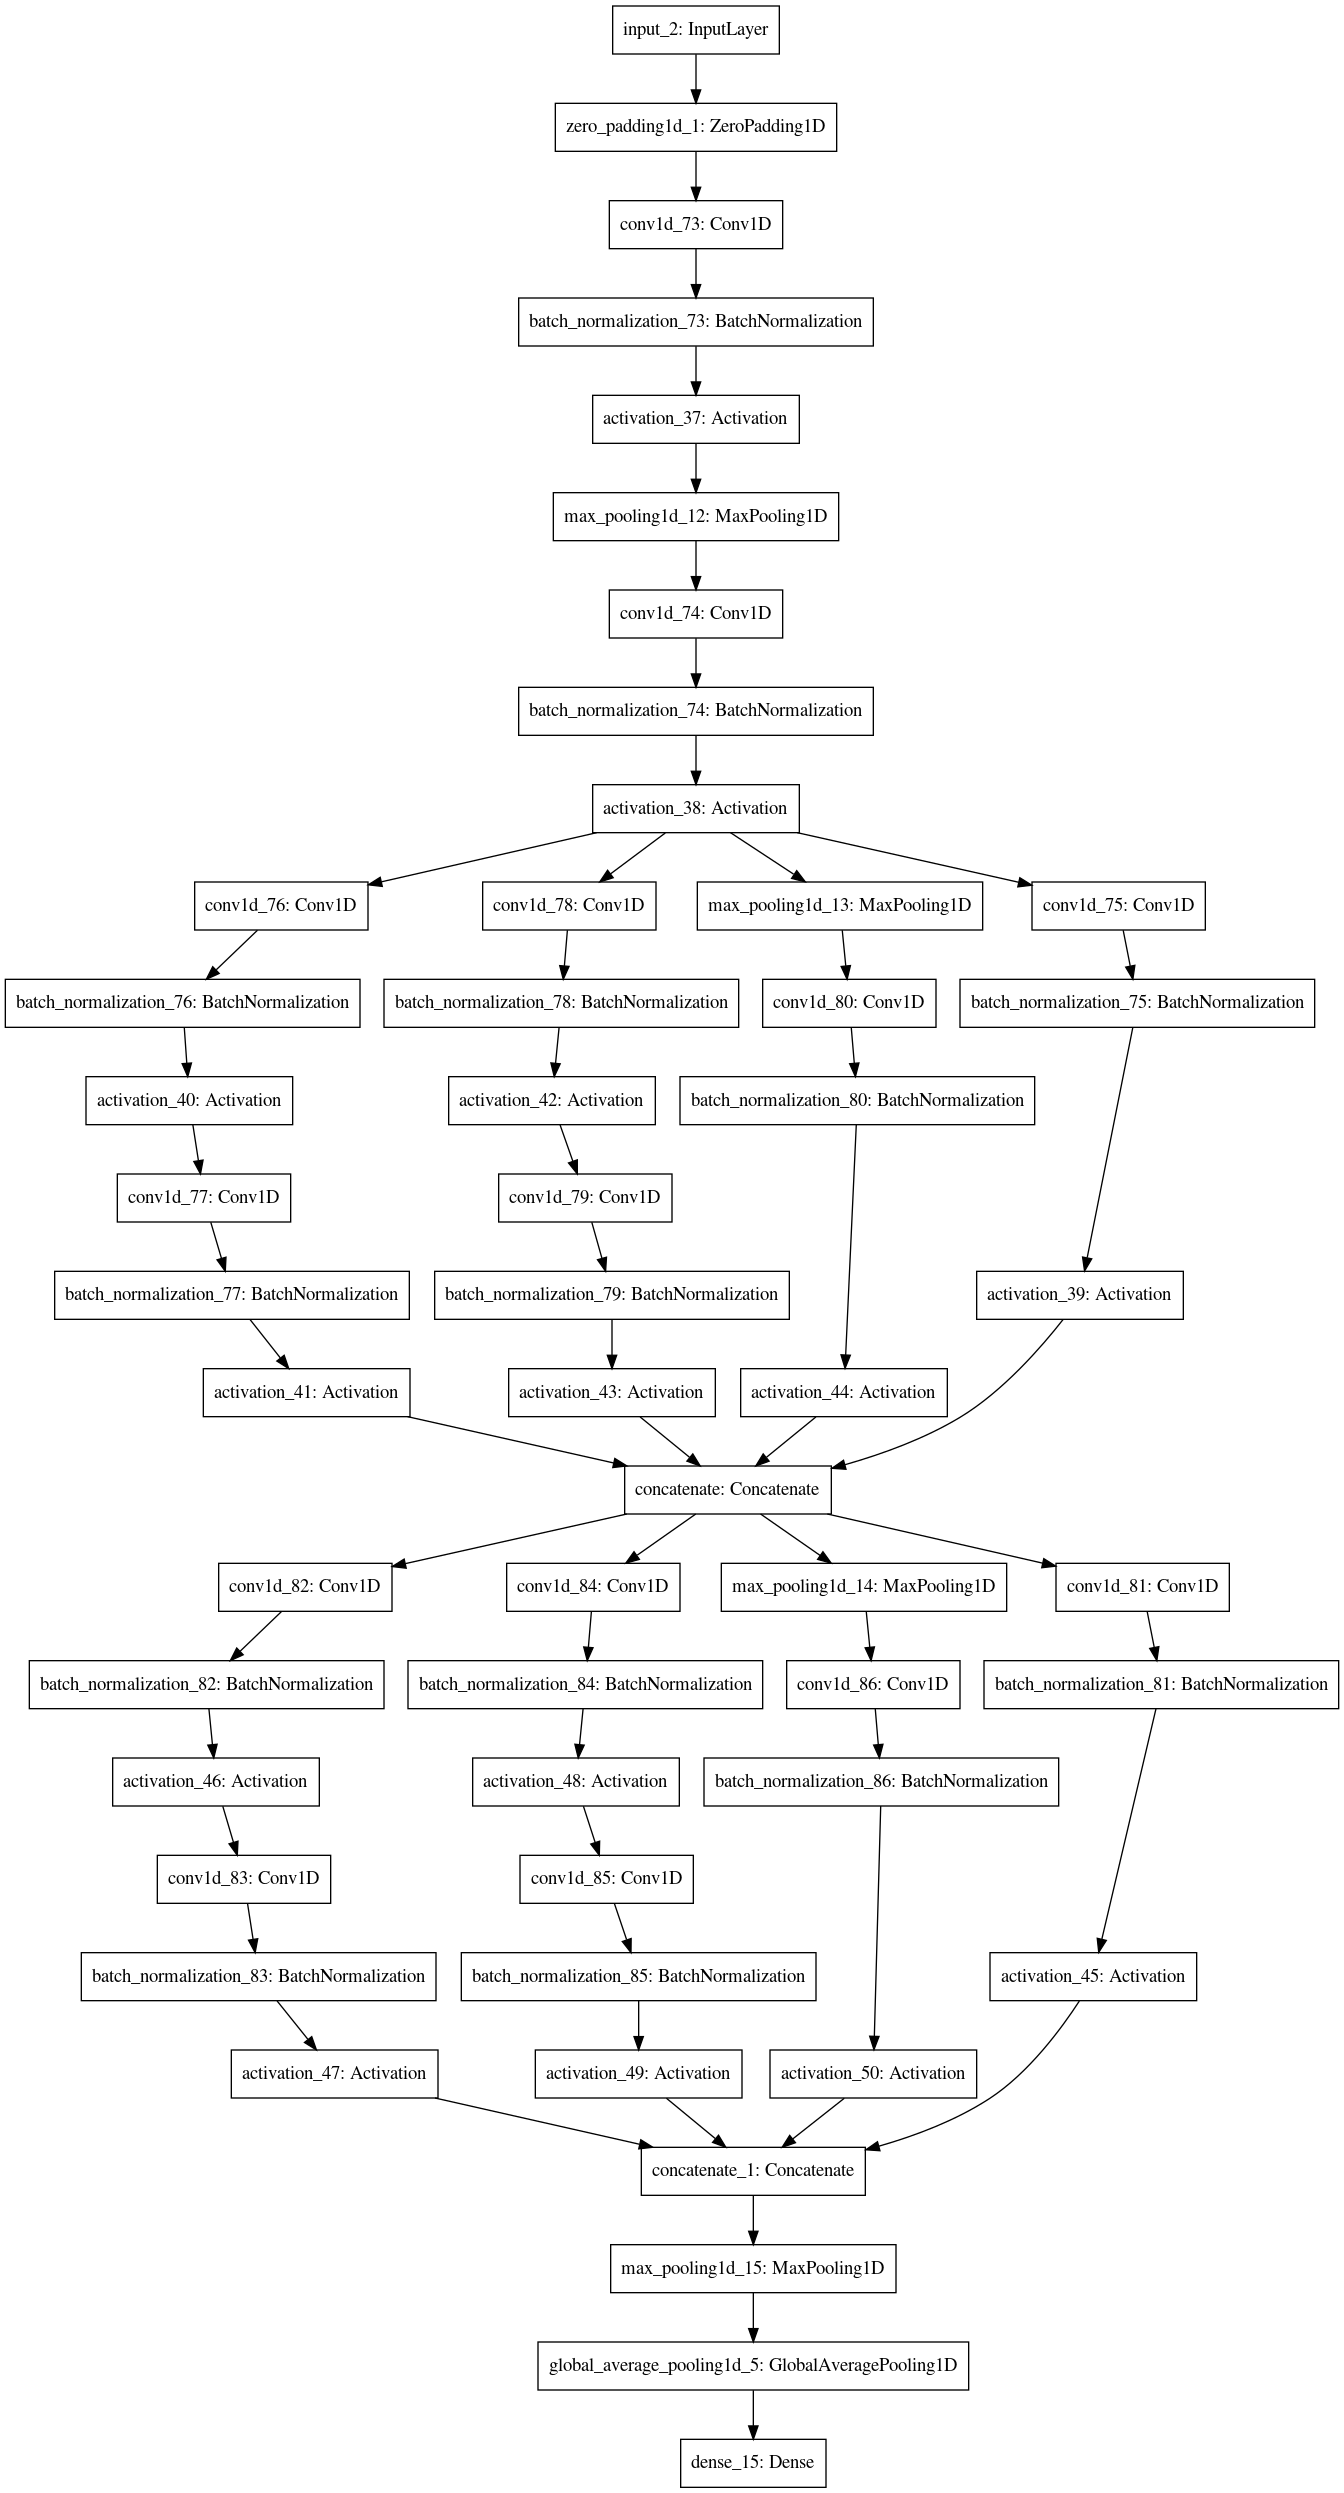

In [87]:
plot_model(inception_model)

In [88]:
batchsize = 10
inception_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 32s 81ms/step - loss: 0.1764 - accuracy: 0.9429 - Recall: 0.2217 - Precision: 0.4030 - AUC: 0.5999 - val_loss: 0.1479 - val_accuracy: 0.9545 - val_Recall: 0.2968 - val_Precision: 0.6310 - val_AUC: 0.7209
Epoch 2/10
388/387 [==============================] - 31s 81ms/step - loss: 0.1417 - accuracy: 0.9544 - Recall: 0.2532 - Precision: 0.6884 - AUC: 0.7109 - val_loss: 0.1484 - val_accuracy: 0.9495 - val_Recall: 0.0773 - val_Precision: 0.6049 - val_AUC: 0.7603
Epoch 3/10
388/387 [==============================] - 32s 82ms/step - loss: 0.1314 - accuracy: 0.9568 - Recall: 0.2685 - Precision: 0.7082 - AUC: 0.7326 - val_loss: 0.1346 - val_accuracy: 0.9571 - val_Recall: 0.3605 - val_Precision: 0.6583 - val_AUC: 0.7867
Epoch 4/10
388/387 [==============================] - 31s 80ms/step - loss: 0.1287 - accuracy: 0.9569 - Recall: 0.3015 - Precision: 0.7115 - AUC: 0.7578 - val_loss: 0.1239 - val_accuracy: 0.9583 - val_Recall: 0.3337 - val_Prec

Text(0, 0.5, 'Accuracy')

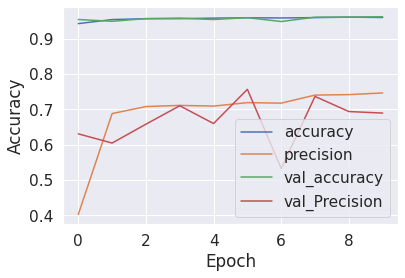

In [89]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

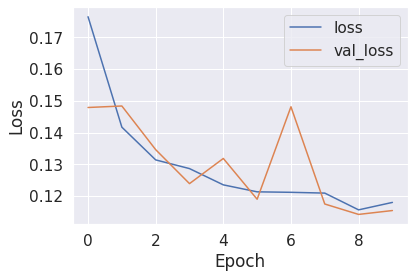

In [90]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

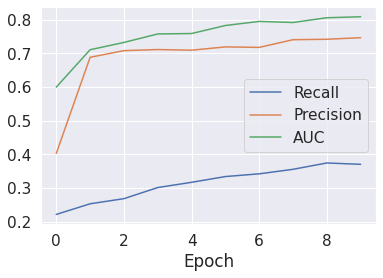

In [91]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [92]:
y_pred = resNet50_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [93]:
init_thresholds = np.arange(0,1,0.05)

In [94]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.14865090446744605
0.020996714829765232
-0.03366338346364113
-0.08691144933845596
-0.13320414962561644
-0.18526433266857822
-0.22723032595089818
-0.27141391427912154
-0.31432766497392806
-0.3562738970942296
-0.39101404315767935
-0.41595362871975844
-0.442311347760738
-0.45968523129284045
-0.47913323523773055
-0.4929256550232704
-0.5116581678180129
-0.5238326700545558
-0.536342298828871
-0.5510447776313943


In [95]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.206532
         Iterations: 638
         Function evaluations: 928


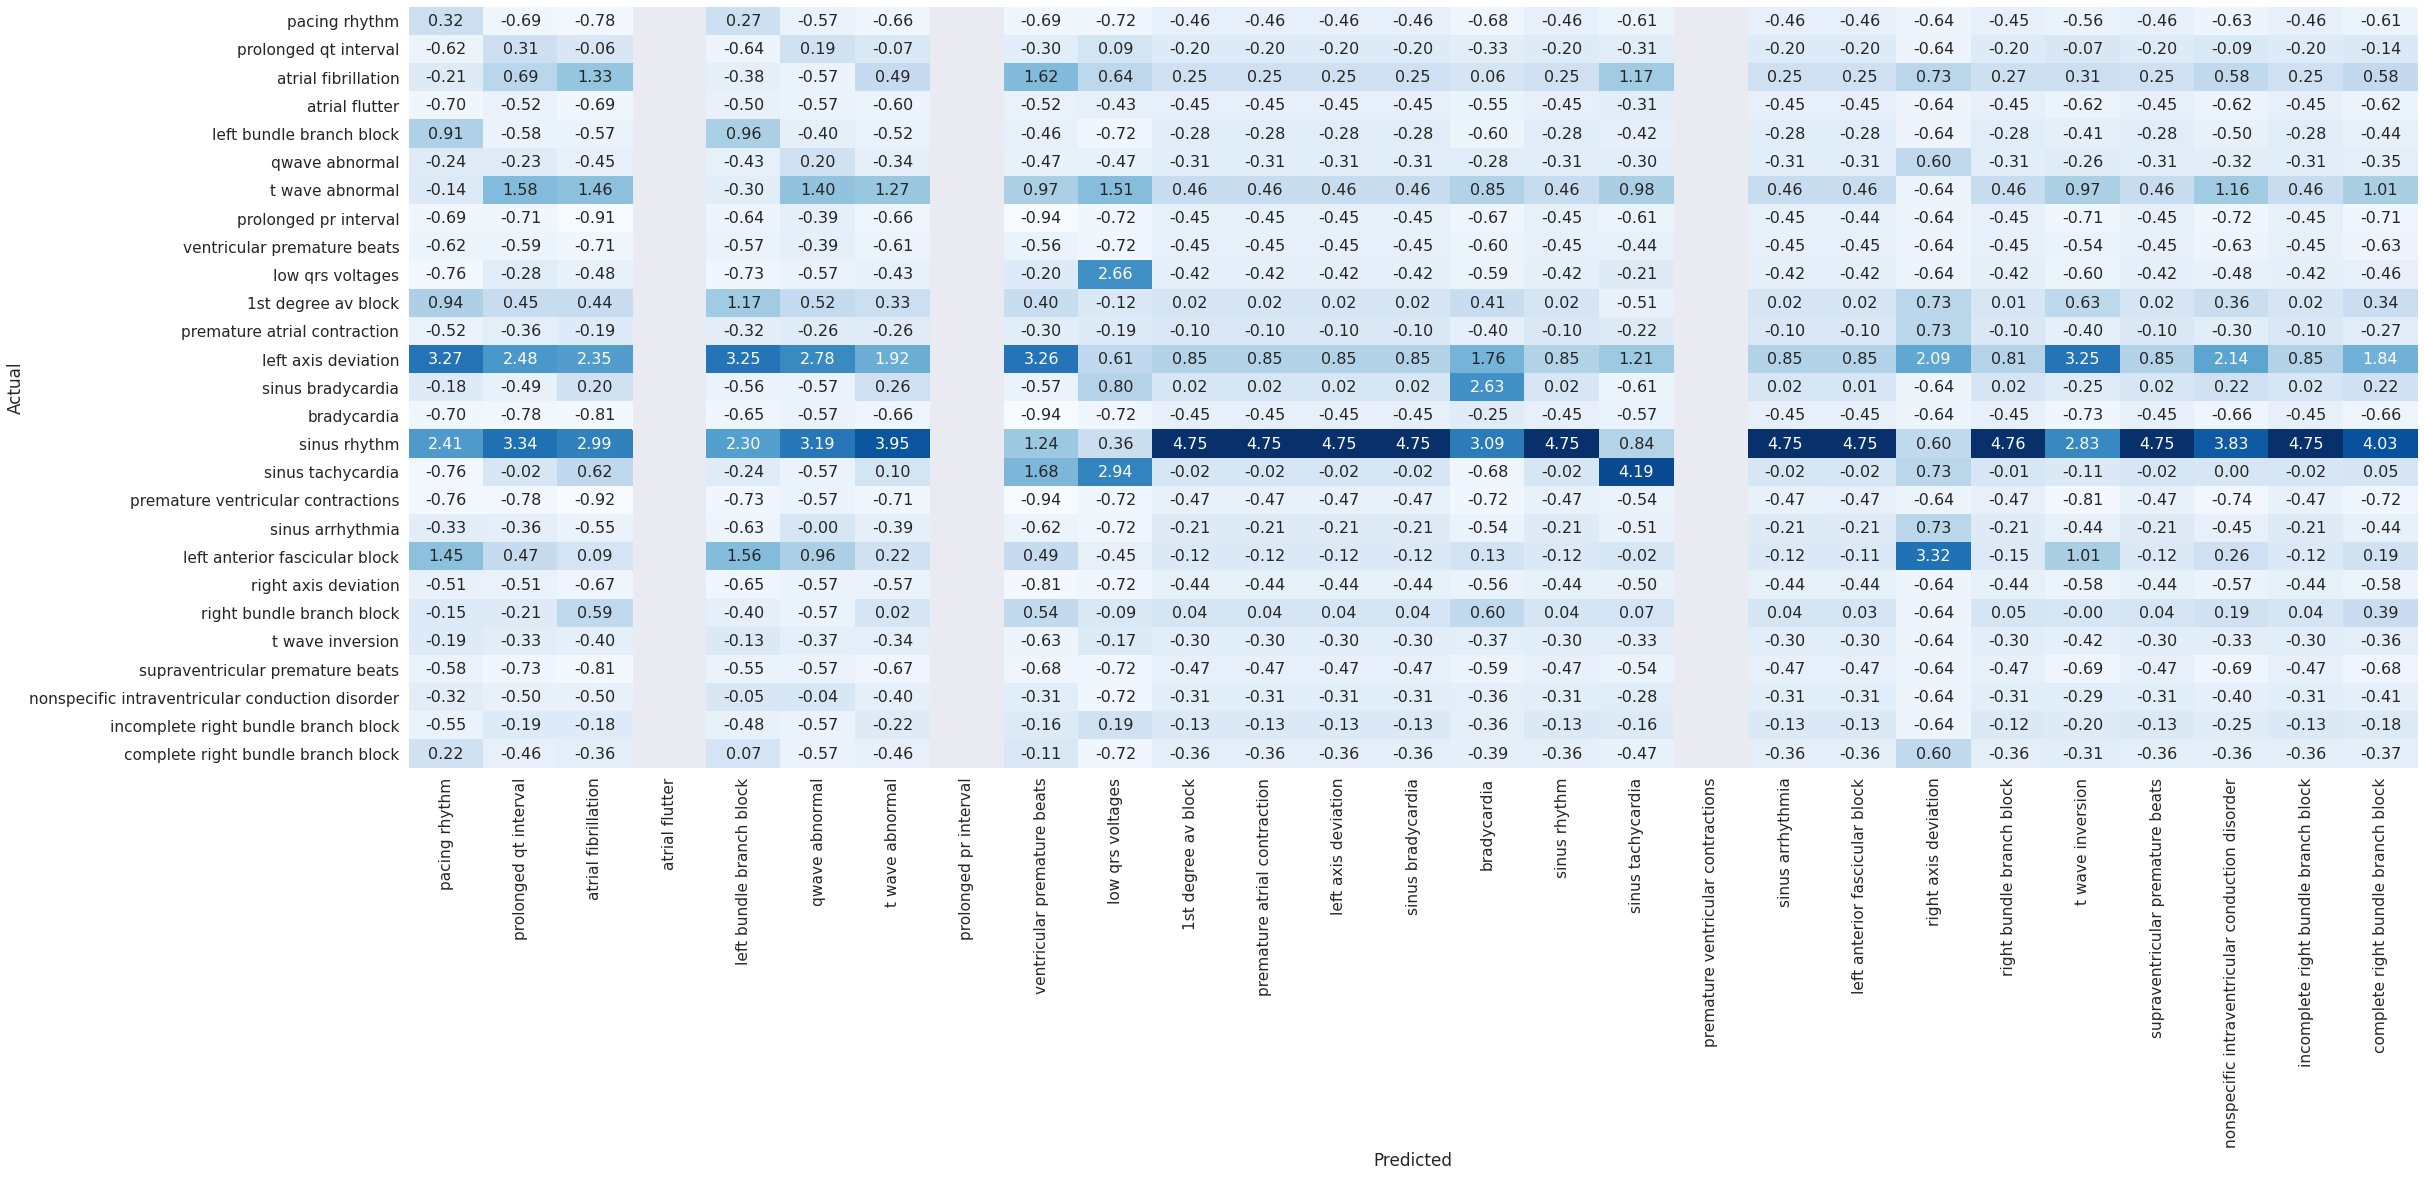

In [96]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_inception.png", dpi=100)

# RNN

# LSTM

In [137]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(5000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(27, activation = 'sigmoid'))

In [138]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [139]:
lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5000, 64)          19712     
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 27)                891       
Total params: 55,707
Trainable params: 55,707
Non-trainable params: 0
_________________________________________________________________


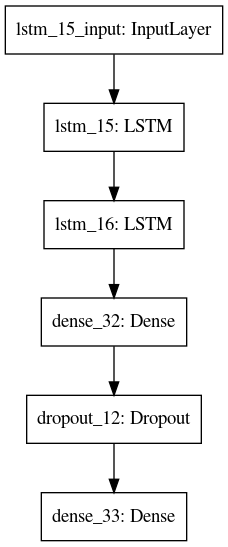

In [140]:
plot_model(lstm_model)

In [141]:
batchsize = 10
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=10, steps_per_epoch=(len(order_array)/(batchsize*10)), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/10
388/387 [==============================] - 135s 349ms/step - loss: 0.2296 - accuracy: 0.9223 - Recall: 0.1912 - Precision: 0.2164 - AUC: 0.5023 - val_loss: 0.1600 - val_accuracy: 0.9523 - val_Recall: 0.2232 - val_Precision: 0.6118 - val_AUC: 0.5385
Epoch 2/10
388/387 [==============================] - 134s 347ms/step - loss: 0.1752 - accuracy: 0.9487 - Recall: 0.1832 - Precision: 0.5459 - AUC: 0.5206 - val_loss: 0.1571 - val_accuracy: 0.9522 - val_Recall: 0.3256 - val_Precision: 0.5701 - val_AUC: 0.5574
Epoch 3/10
388/387 [==============================] - 133s 342ms/step - loss: 0.1664 - accuracy: 0.9516 - Recall: 0.2171 - Precision: 0.6125 - AUC: 0.5381 - val_loss: 0.1538 - val_accuracy: 0.9552 - val_Recall: 0.3124 - val_Precision: 0.6415 - val_AUC: 0.5765
Epoch 4/10
388/387 [==============================] - 134s 346ms/step - loss: 0.1646 - accuracy: 0.9524 - Recall: 0.2276 - Precision: 0.6167 - AUC: 0.5300 - val_loss: 0.1536 - val_accuracy: 0.9548 - val_Recall: 0.2244 - 

Text(0, 0.5, 'Accuracy')

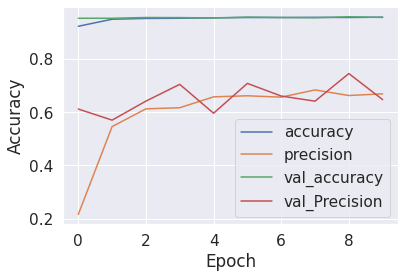

In [142]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

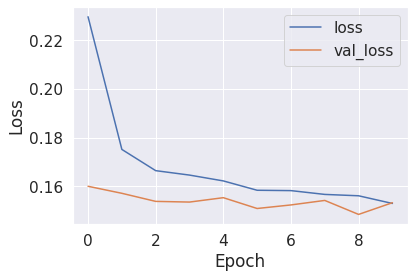

In [143]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

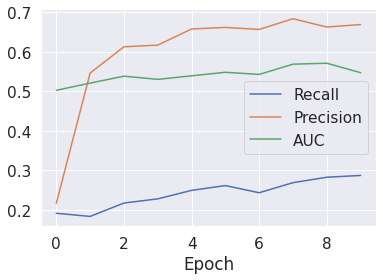

In [144]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [145]:
y_pred = lstm_model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [146]:
init_thresholds = np.arange(0,1,0.05)

In [147]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.15319576569017423
0.09082927493745215
0.04777184824162447
-0.024293333991957797
-0.05233606094681511
-0.08390984383988524
-0.10021150135875644
-0.11509377072177317
-0.13049869435760278
-0.1504647869452803
-0.1844065750927513
-0.2404667031158048
-0.3631606678663982
-0.4225202709907021
-0.5867434968873652
-0.7670181419549381
-0.8224511289966577
-0.8238661257831744
-0.8238661257831744


In [148]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.153481
         Iterations: 4
         Function evaluations: 88


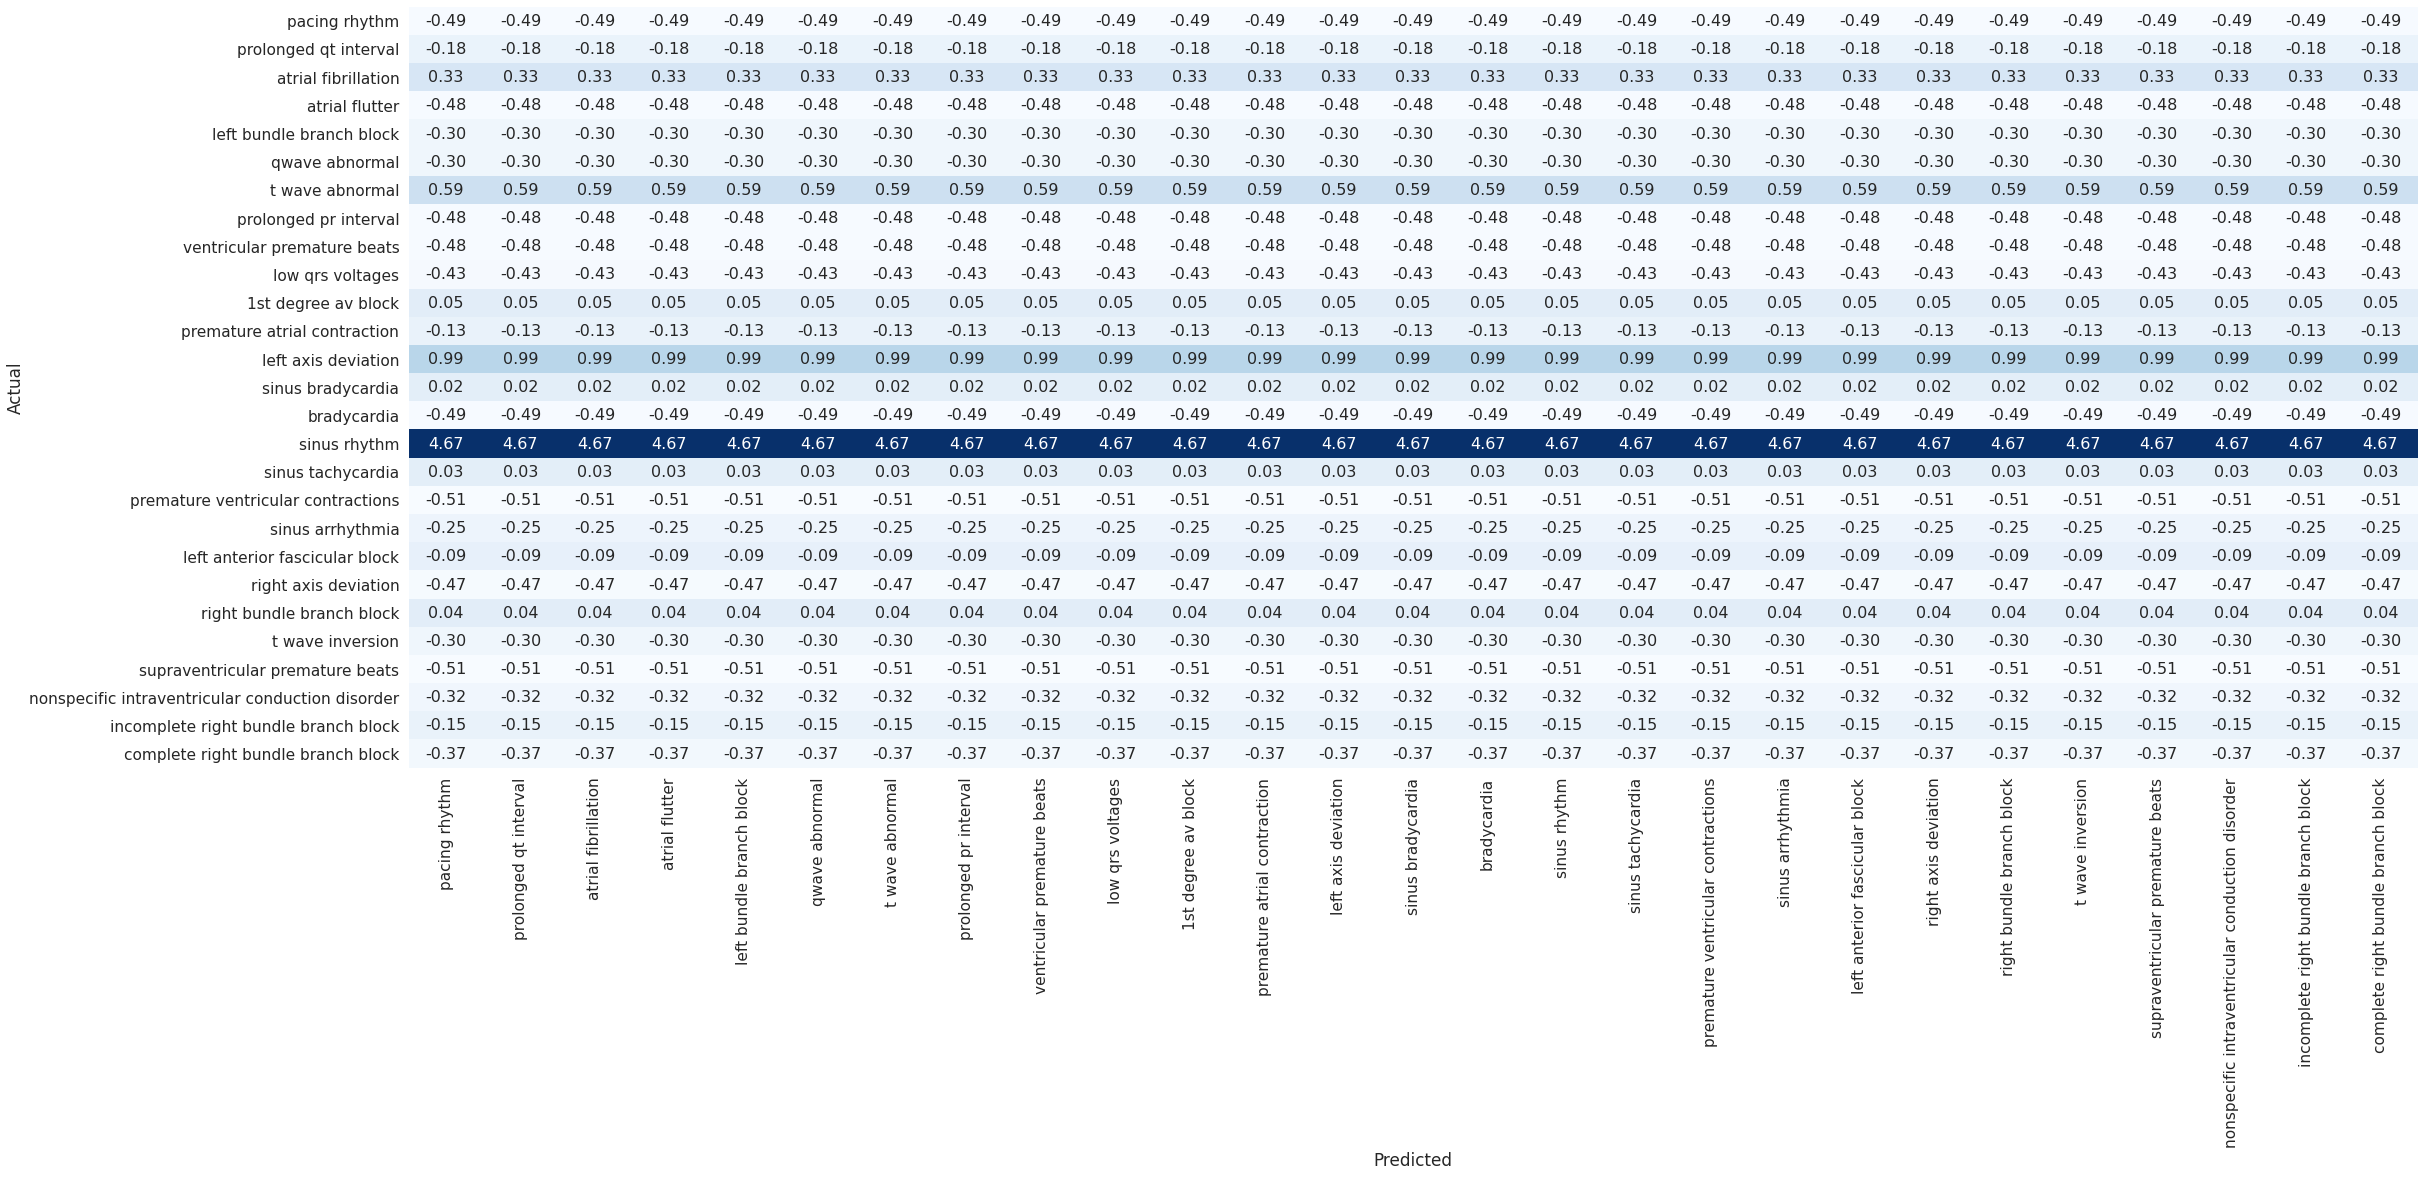

In [149]:
plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes)
plt.savefig("confusion_matrix_lstm.png", dpi=100)